In [9]:
#github.com/tamas-ferenci/MagyarorszagKozutiElerhetoseg
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(12,7)})
sns.set_theme()
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats#only for p_value
import re#glm feature processing
import warnings
import copy
import numpy as np

########################################################################################################

def encode_bitwise(M, T):
    return (M << 32) | T

def decode_bitwise(encoded):
    M = encoded >> 32
    T = encoded & ((1 << 32) - 1)
    return M, T

def plot_cumulative_sum(df,GroupByCol,ValueCol='V'):
    # Sort the DataFrame by the specified 'odometer' column
    df_sorted = df.sort_values(by=GroupByCol)
    df_sorted['W']=1
    avg_GroupByCol = df_sorted[ValueCol].mean()
    # Compute the cumulative sum of ValueCol
    df_sorted['cumulative_sum'] = df_sorted[ValueCol].cumsum()
    df_sorted['count'] = df_sorted['W'].cumsum() * avg_GroupByCol
    plt.figure(figsize=(10, 6))
    plt.plot(df_sorted[GroupByCol], df_sorted['cumulative_sum'], marker='o', color='b')
    plt.plot(df_sorted[GroupByCol], df_sorted['count'], label='Count', marker='x', color='r')
    plt.title('Cumulative Sum of '+GroupByCol+' vs '+ValueCol)
    plt.xlabel(GroupByCol)
    plt.ylabel('Cumulative Sum of '+ValueCol)
    plt.grid(True)
    plt.show()

# Custom loss function
def custom_loss(preds, dtrain):
    # Get true values
    G = dtrain.get_label()  # This is the encoded G column
    
    # Decode G into M and T
    M, T = decode_bitwise(G.astype(int))  # Ensure G is treated as int

    # Constants
    a, b, c = 1.0, 0.1, 0.2

    # Compute loss and gradient based on conditions
    grad = np.zeros_like(preds)  # Gradient (first derivative)
    hess = np.zeros_like(preds)  # Hessian (second derivative)

    # Compute gradients and Hessians for each condition
    for i in range(len(preds)):
        P = preds[i]
        if P > T[i] > M[i]:
            grad[i] = -2 * (T[i] - P) * a
            hess[i] = 2 * a
        elif T[i] > P > M[i]:
            grad[i] = -2 * (T[i] - P) * a * np.exp(-b * (P - M[i]))
            hess[i] = 2 * a * np.exp(-b * (P - M[i])) * (1 - b * (T[i] - P))
        elif T[i] > M[i] > P:
            grad[i] = -2 * (T[i] - P)
            hess[i] = 2
        elif P > M[i] > T[i]:
            grad[i] = -2 * (T[i] - P) * np.exp(-c * (P - M[i]))
            hess[i] = 2 * np.exp(-c * (P - M[i])) * (1 - c * (T[i] - P))
        elif M[i] > P > T[i]:
            grad[i] = -2 * (M[i] - P)
            hess[i] = 2
        elif M[i] > T[i] > P:
            grad[i] = -2 * (M[i] - P)
            hess[i] = 2

    return grad, hess

def RecommendBandingFunc(result, GroupByCol):
    binning_list = []
    for i in range(len(result)):
        current_row = result.loc[i]
        # Always include the first value
        if i != 0 and ((last_binned_rowSE_Lower <= current_row['V'] <= last_binned_rowSE_Upper) or \
                       (current_row['SE_Lower'] <= last_binned_rowV <= current_row['SE_Upper'])):
            pass
        else:
            # If none of the conditions are met, include i
            binning_list.append(current_row[GroupByCol])
            last_binned_rowV=current_row['V']
            last_binned_rowSE_Lower=current_row['SE_Lower']
            last_binned_rowSE_Upper=current_row['SE_Upper']
    return(binning_list)

def plotave(df, GroupByColList, WeightCol='W', ValueCol='V', PredictedCol=None, ChallengerCol=None, PrintTable=None, nbins=None, lower=None, upper=None
             ,show2SE=True, resetXaxis=False, polinomDegree=None, recommendBanding=False, silent=False
            ,sortby=None,axis1name='Exposure',axis2name='Claim Count',charttitle='Exposure and Claim Frequency by '):
    if not isinstance(GroupByColList, list):
        GroupByColList=[GroupByColList]
    if WeightCol not in df.columns:
        Set1Weights=True
    else:
        Set1Weights=False
    for GroupByCol in GroupByColList:
        # Group by GroupByCol and aggregate
        result=df.copy()
        if lower is not None:
            result[GroupByCol]=np.maximum(lower, result[GroupByCol])
        if upper is not None:
            result[GroupByCol]=np.minimum(upper, result[GroupByCol])
        if nbins is not None:
            #print(pd.Series(result['bins'].unique()).sort_values().reset_index(drop=True))
            result['bins']=pd.qcut(result[GroupByCol], q=nbins, duplicates='drop')
            result['ori']=result[GroupByCol]
            result[GroupByCol] = result.groupby('bins')[GroupByCol].transform('min')
            #print(result.drop_duplicates(subset=['ori',GroupByCol,'bins']).sort_values(by='ori').reset_index(drop=True))
            #print(result)
            #result[GroupByCol]=result[GroupByCol].groupby(bins).min()
        if Set1Weights:
            result['W'] = 1
            WeightCol = 'W'
        result = result.groupby(GroupByCol).agg(
            W=(WeightCol, 'sum'),
            V=(ValueCol, 'mean'),
            P=(PredictedCol if PredictedCol is not None else ValueCol, 'mean'),
            C=(ChallengerCol if ChallengerCol is not None else ValueCol, 'mean'),
            Std=(ValueCol, 'std')
        ).reset_index()
        
                


        # Calculate Standard Error
        result['SE_Lower']=result['V']-2*result["Std"]/np.sqrt(result['W'])
        result['SE_Upper']=result['V']+2*result["Std"]/np.sqrt(result['W'])

        # Sorting
        if sortby is None:
            sortby=GroupByCol
            result = result.sort_values(by=sortby).reset_index(drop=True)


        # Optinally recommend binning, using upper, lower and nbins, before of optional resetXaxis
        if recommendBanding:
            binning_df=RecommendBandingFunc(result, GroupByCol)

        if not silent:
            if resetXaxis:
                result['value']=result[GroupByCol]
                # Compute ranks
                ranked_series = result[GroupByCol].rank(method='dense', ascending=True)
                # Create dictionary mapping original values to their ranks
                rank_dict = dict(zip(result[GroupByCol], ranked_series))
                # Apply ranking to the column (replacing values)
                result[GroupByCol] = ranked_series

            # Plotting
            fig, ax1 = plt.subplots()

            # Bar chart for the sum of Exposure
            ax1.bar(result[GroupByCol], result['W'], color='b', alpha=0.6, label='Exposure')
            ax1.set_xlabel(GroupByCol)
            ax1.set_ylabel(axis1name, color='b')

            # Create a second y-axis for the line chart
            ax2 = ax1.twinx()
            ax2.plot(result[GroupByCol], result['V'], color='r', marker='o', label='Actual')
            ax2.set_ylabel(axis2name, color='r')

            # Optionally Plot Predicted
            if PredictedCol is not None:
                ax2.plot(result[GroupByCol], result['P'], color='orange', marker='o', label='Predicted')
            if ChallengerCol is not None:
                ax2.plot(result[GroupByCol], result['C'], color='yellow', marker='o', label='Predicted')

            # Optionally plot +/- 2× Standard Error
            if show2SE:
                ax2.fill_between(result[GroupByCol], result['SE_Lower'], result['SE_Upper'], color='r', alpha=0.2, label='Actual ±2 Standard Error')

            # Optinally fit polinom (if ResetXaxis then on 1,2,3,... otherwise on actual numbers)
            if polinomDegree is not None:
                coefficients = np.polyfit(result[GroupByCol], result['V'], polinomDegree, w=result['W'])
                polynomial = np.poly1d(coefficients)
                y_fit = polynomial(result[GroupByCol])
                ax2.plot(result[GroupByCol], y_fit, color='g', label='Fitted')



            fig.suptitle(charttitle + GroupByCol)

            # Add legends
            ax1.legend(loc='upper left')
            ax2.legend(loc='upper right')

            plt.show()

            # Optionally Print Table in shortened or full view
            if PrintTable==1:
                print(result)
            if PrintTable==2:
                print(result.to_string(index=False))

            # Printing if banding recommendation requested
            if recommendBanding:
                print(binning_df)
                if resetXaxis:
                    # Filter rank_dict to only include values present in binning_df (which is a list)
                    filtered_rank_dict = {k: v for k, v in rank_dict.items() if k in binning_df}
                    # Convert dictionary to a DataFrame for tabular display
                    rank_table = pd.DataFrame([filtered_rank_dict.keys(), filtered_rank_dict.values()],
                                              index=["Original Value", "Rank"])
                    print(rank_table.to_string(index=True, header=False))

        elif recommendBanding:
            #return(binning_df)
            pass

def applyBanding(value, banding_values):
    # Find the greatest value in banding_values that is not greater than value
    bandedValue = max((b for b in banding_values if b <= value), default=min(banding_values))
    return bandedValue

def add_banding_columns(df, bandings):
    """
    For each key (column name) in the bandings dictionary,
    apply the applyBanding function to that column using the provided banding values,
    and create a new column with a leading underscore.
    
    Parameters:
        df (pandas.DataFrame): The input DataFrame.
        bandings (dict): A dictionary where keys are column names and values are lists of banding values.
    
    Returns:
        pandas.DataFrame: The DataFrame with new banded columns added.
    """
    for col, values in bandings.items():
        new_col = '_' + col  # prepend an underscore to the original column name
        df[new_col] = df[col].apply(applyBanding, banding_values=values)
    return df

########################################################################################################

df = pd.read_excel('/kaggle/input/v-type-data/kgfb_sim_fr_feb01.xlsx')

In [2]:
# Reload dataset (adjusted for possible NaNs)

#df = pd.get_dummies(df, columns=['fuel', 'payment_method'], drop_first=True)

This feature recommends you a binning in respect to double standard error:

In [3]:
plotave(df,'VehPower',recommendBanding=True)

[4.0, 5.0, 7.0, 8.0, 10.0]


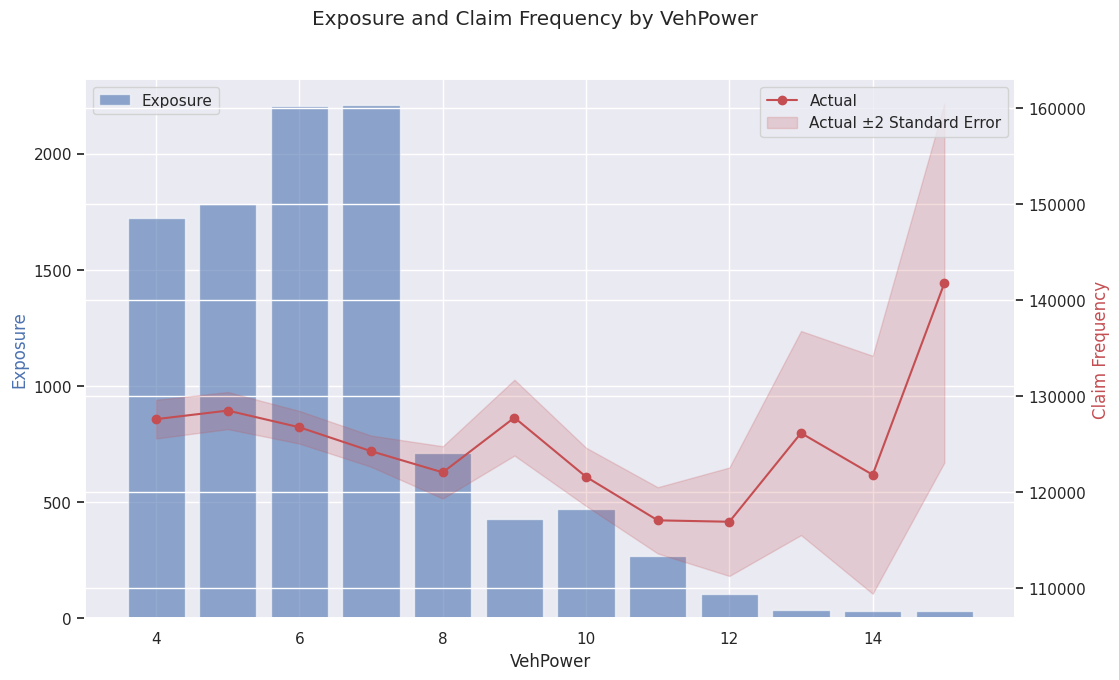

[4.0, 7.0, 11.0, 15.0]


In [4]:
plotave(df,'VehPower',ValueCol='M',recommendBanding=True)

In [5]:
plotave(df,'DrivAge',recommendBanding=True)

[18.0, 20.0, 74.0, 79.0, 81.0]


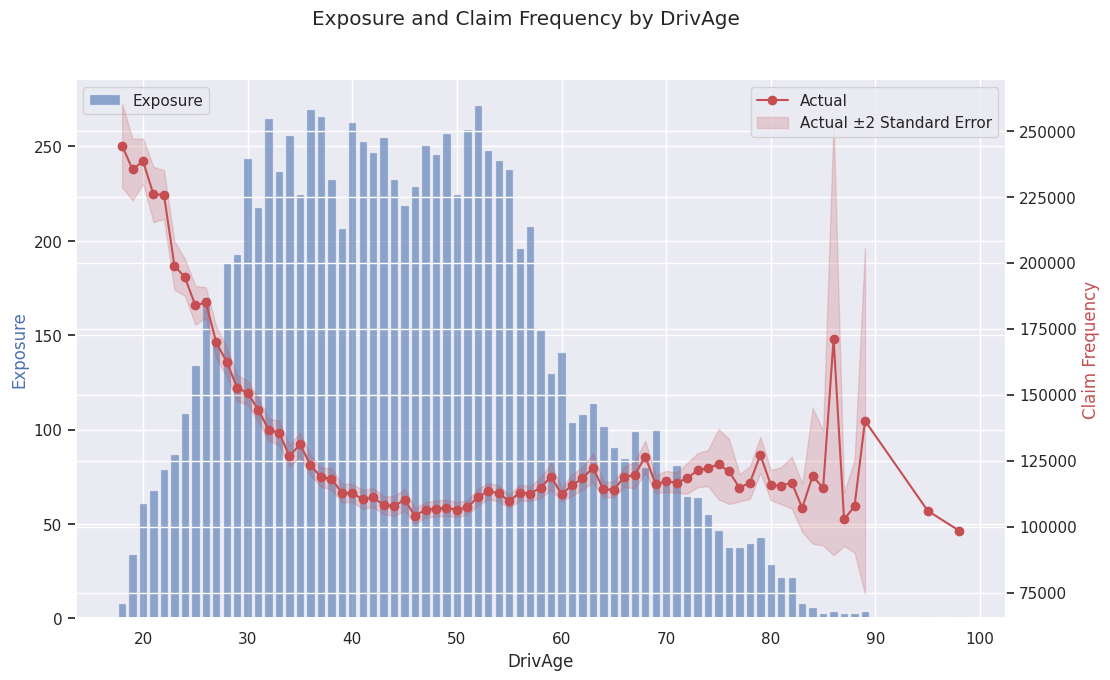

[18.0, 21.0, 23.0, 25.0, 27.0, 28.0, 29.0, 31.0, 32.0, 34.0, 37.0, 39.0, 43.0, 46.0, 51.0, 52.0, 59.0, 60.0, 62.0, 68.0, 69.0, 79.0, 80.0, 87.0]


In [6]:
plotave(df,'DrivAge',ValueCol='M',recommendBanding=True)

In [7]:
plotave(df,'VehAge',recommendBanding=True)

[0.0, 1.0, 4.0, 14.0, 21.0]


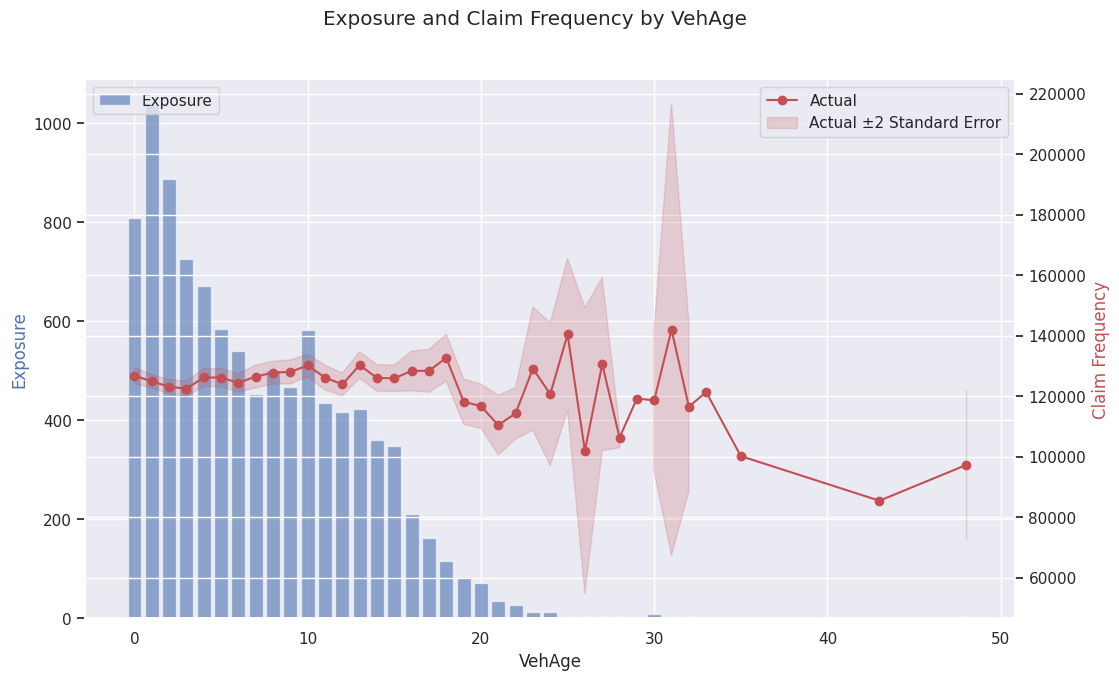

[0.0, 2.0, 4.0, 10.0, 12.0, 13.0, 19.0, 28.0, 29.0, 33.0, 35.0, 43.0]


In [8]:
plotave(df,'VehAge',ValueCol='M',recommendBanding=True)

In [9]:
plotave(df,'BonusMalus',recommendBanding=True)

[50.0, 51.0, 55.0, 64.0, 70.0, 72.0, 81.0, 85.0, 86.0, 90.0, 92.0, 95.0, 96.0, 100.0, 107.0, 111.0, 112.0, 113.0, 126.0, 133.0, 140.0, 147.0, 148.0, 156.0, 165.0]


In [10]:
plotave(df,'BonusMalus',ValueCol='M',recommendBanding=True)

[50.0, 51.0, 52.0, 54.0, 57.0, 60.0, 62.0, 67.0, 68.0, 71.0, 73.0, 74.0, 83.0, 89.0, 91.0, 93.0, 95.0, 97.0, 99.0, 100.0, 107.0, 111.0, 112.0, 125.0, 126.0, 132.0, 147.0, 148.0, 156.0, 165.0]


In [11]:
plotave(df,['licence_age'],WeightCol=None, recommendBanding=True)

[0.0, 33.0]


It seems that licence_age doesn't strongly correlate with the likelihood of causing claims. Let's explore how the market price varies with licence_age.

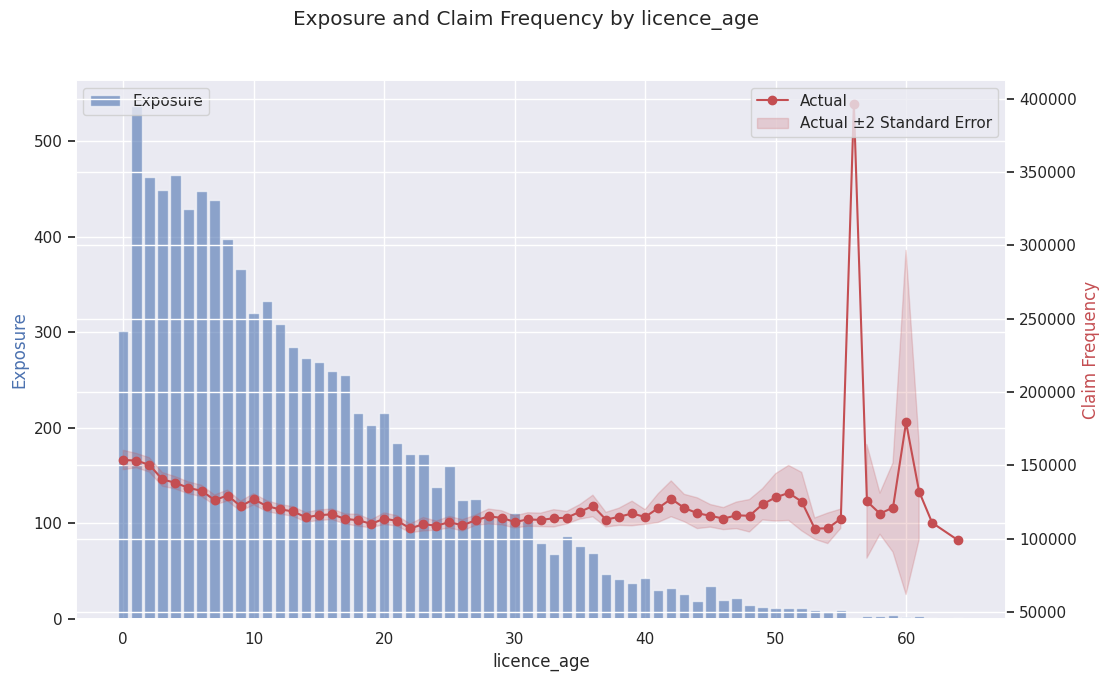

[0.0, 3.0, 5.0, 7.0, 9.0, 10.0, 11.0, 14.0, 19.0, 22.0, 25.0, 35.0, 37.0, 42.0, 46.0, 56.0, 57.0]


In [12]:
plotave(df,['licence_age'],WeightCol=None, ValueCol='M', recommendBanding=True)

In [11]:
plotave(df,['licence_age'],WeightCol=None, ValueCol='M', polinomDegree=2
        ,charttitle='Claim Count and Exposure by '
        , axis1name='Claim Count',axis2name='Exposure')#hacking!!

Much more impressive. The banding looks good (except for 56 & 57), but let's see how a polynomial fit performs.

With a reasonable cap at 35 years, this might provide a better estimate for risk. However, when modeling market price, we should allow for stronger overfitting compared to risk modeling. Personally, I prefer the banding approach instead. Insert into our banding part. Note that banded variables starts with an _
Continue to n_drivers

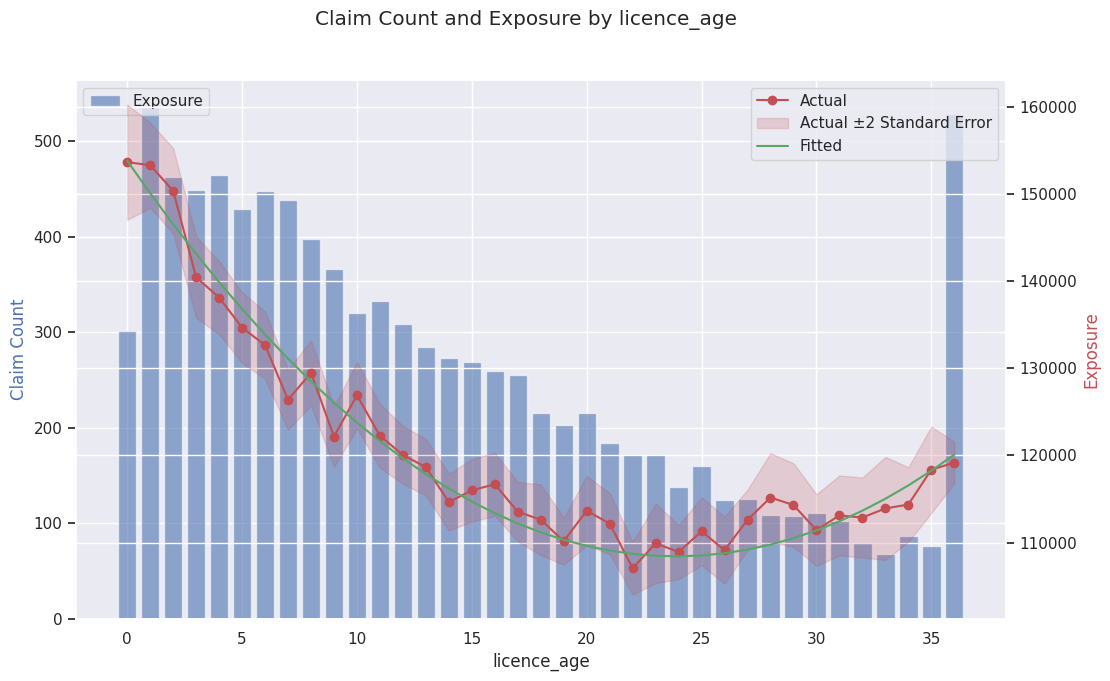

In [12]:
plotave(df,['licence_age'],WeightCol=None, ValueCol='M', polinomDegree=2, upper=36
        ,charttitle='Claim Count and Exposure by '
        , axis1name='Claim Count',axis2name='Exposure')#hacking!!

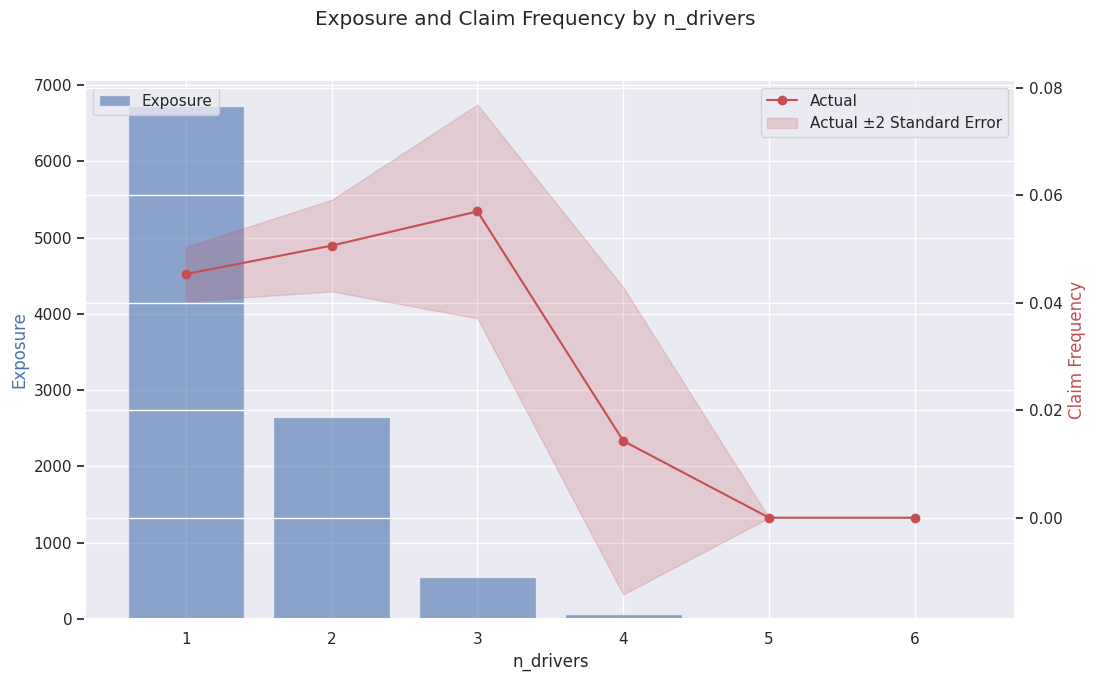

[1.0, 4.0]


In [14]:
plotave(df,['n_drivers'], recommendBanding=True)

The effect is significant, but the exposure is minimal. Let's take a look at the market price in relation to the number of drivers.

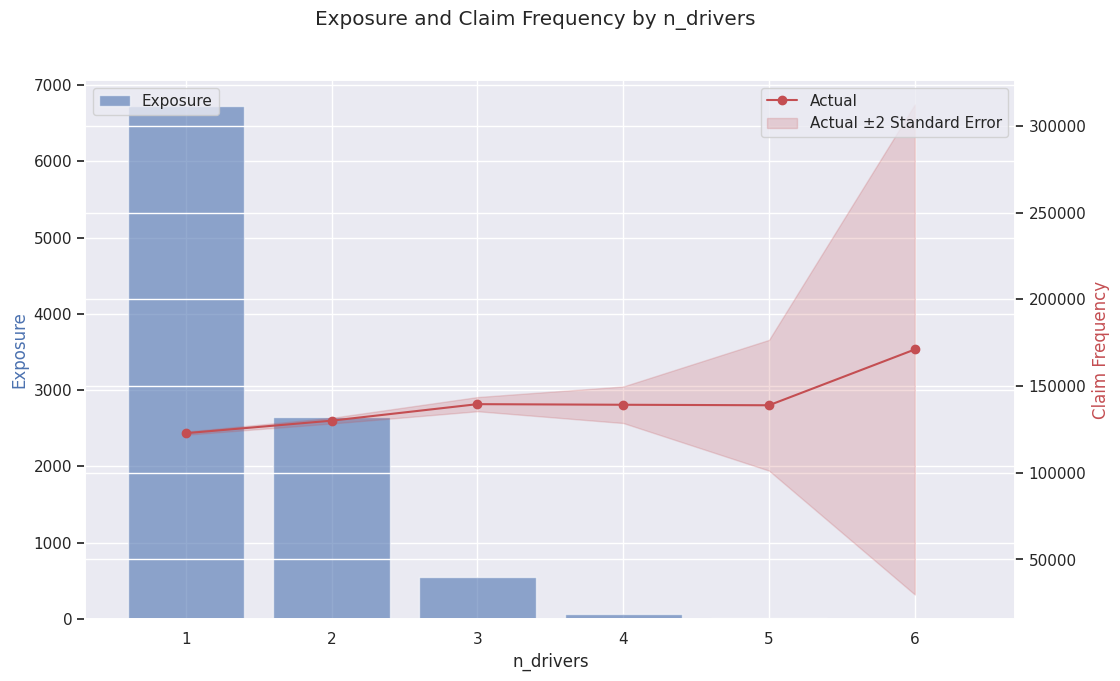

[1.0, 2.0, 3.0]


In [15]:
plotave(df,['n_drivers'],WeightCol=None, ValueCol='M', recommendBanding=True)

Clearly accepted

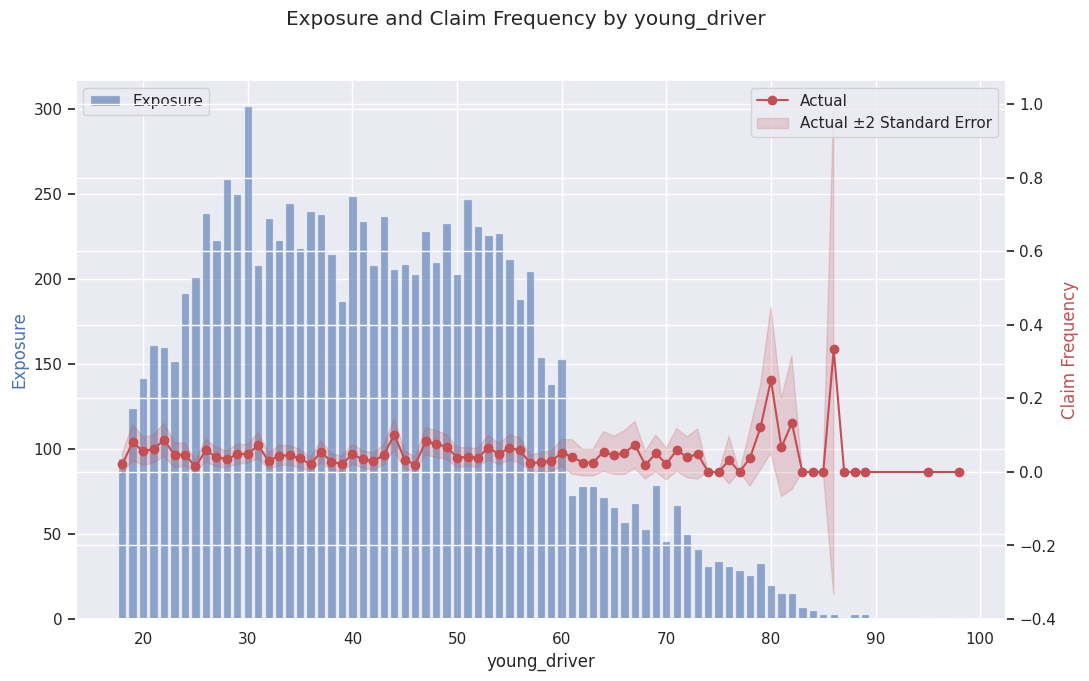

[18.0, 19.0, 25.0, 26.0, 36.0, 37.0, 39.0, 44.0, 45.0, 47.0, 50.0, 74.0, 79.0, 83.0]


In [16]:
plotave(df,['young_driver'],WeightCol=None, recommendBanding=True)

Now, I can't capture the important part clearly because the data becomes erratic starting from 79. This part won’t be refined anyway.

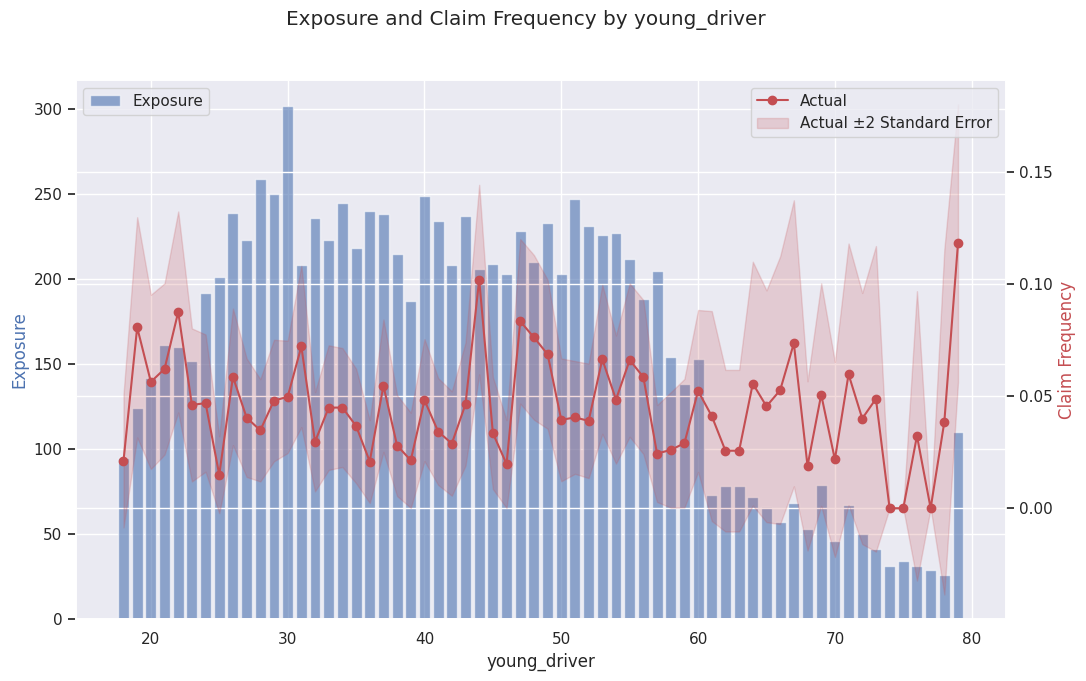

[18.0, 19.0, 25.0, 26.0, 36.0, 37.0, 39.0, 44.0, 45.0, 47.0, 50.0, 74.0, 79.0]


In [17]:
plotave(df,['young_driver'],WeightCol=None, recommendBanding=True, upper=79)

I reject this as a risk explanatory factor. Let’s see how relevant it is as a market price determinant.

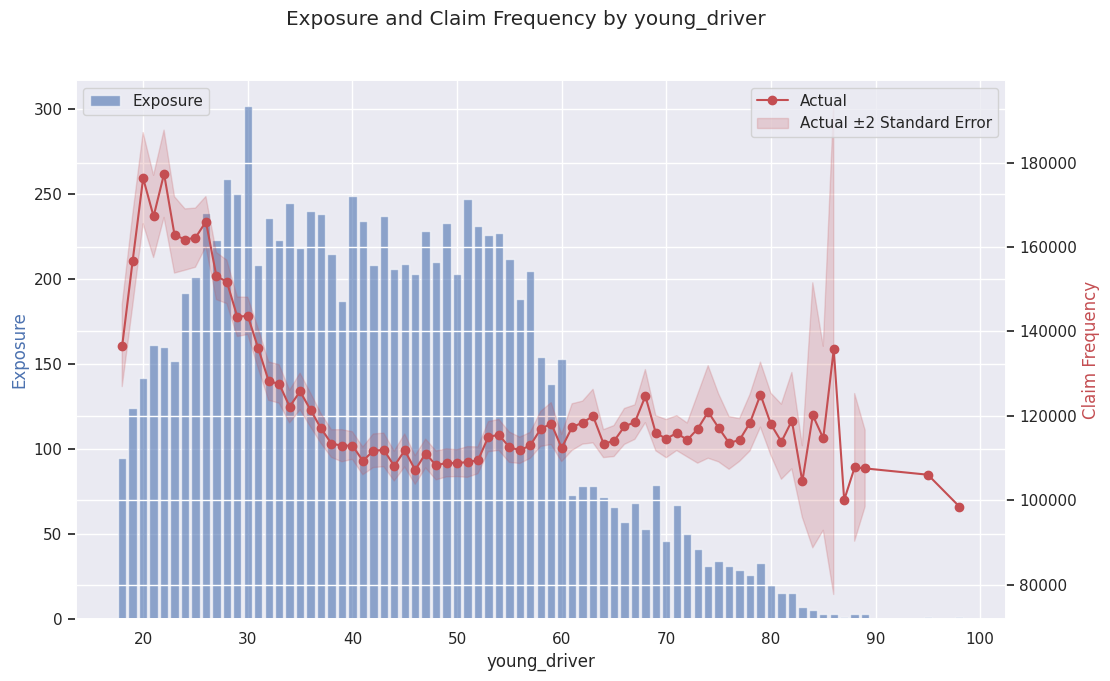

[18.0, 19.0, 20.0, 23.0, 27.0, 29.0, 31.0, 32.0, 34.0, 37.0, 38.0, 41.0, 53.0, 68.0, 69.0, 79.0, 81.0, 83.0]


In [18]:
plotave(df,['young_driver'],WeightCol=None, ValueCol='M', recommendBanding=True)

It's OK, except 81&83

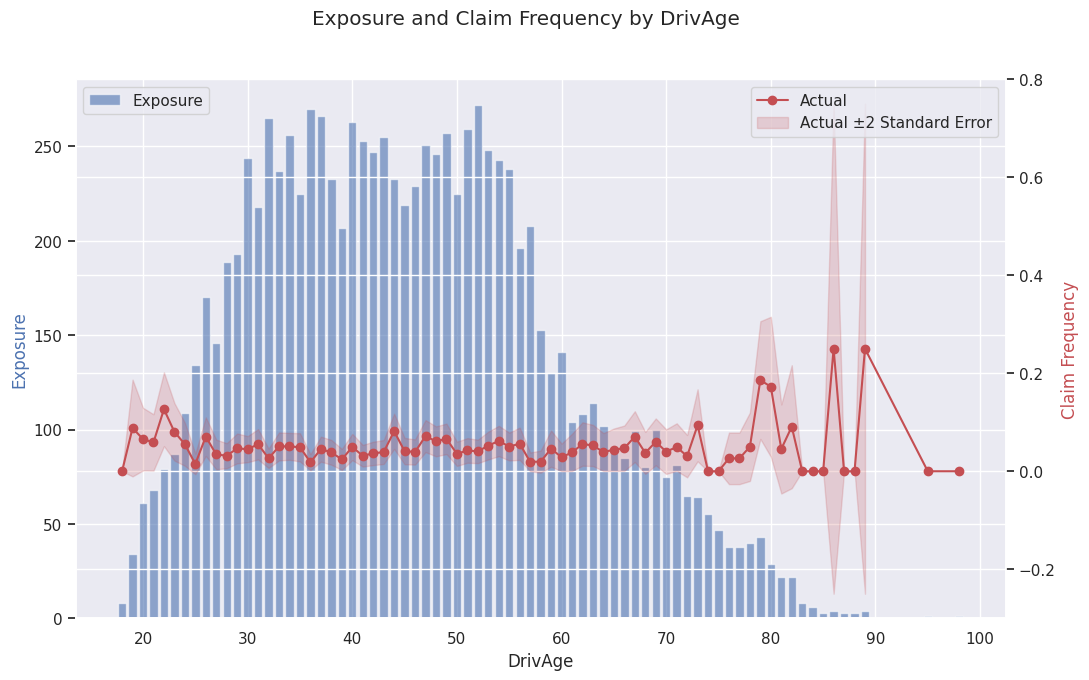

[18.0, 20.0, 74.0, 79.0, 81.0]


In [19]:
plotave(df,['DrivAge'],WeightCol=None, recommendBanding=True)

rejected

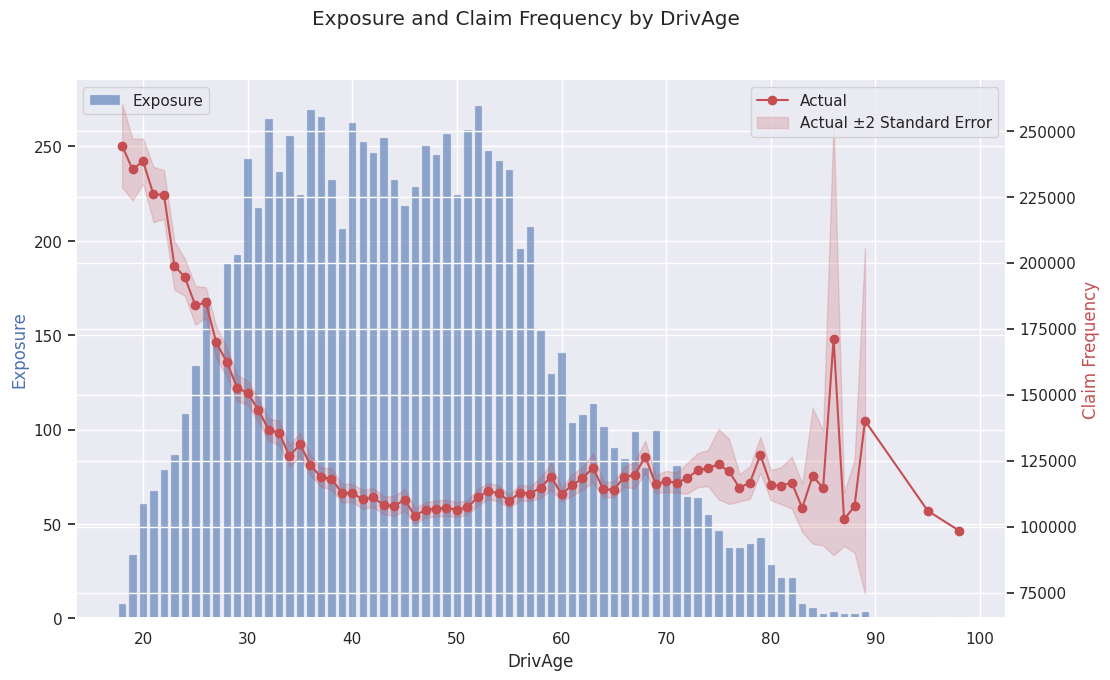

[18.0, 21.0, 23.0, 25.0, 27.0, 28.0, 29.0, 31.0, 32.0, 34.0, 37.0, 39.0, 43.0, 46.0, 51.0, 52.0, 59.0, 60.0, 62.0, 68.0, 69.0, 79.0, 80.0, 87.0]


In [20]:
plotave(df,['DrivAge'],WeightCol=None, ValueCol='M', recommendBanding=True)

Accepted until 69

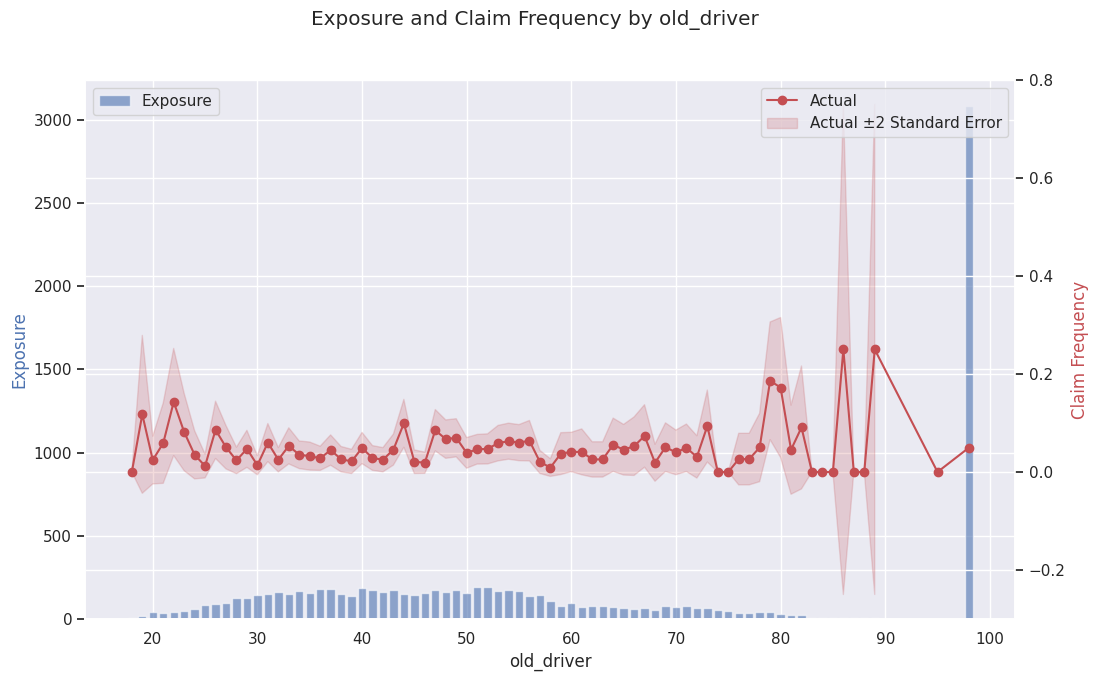

[18.0, 22.0, 25.0, 26.0, 28.0, 44.0, 45.0, 47.0, 50.0, 74.0, 79.0, 81.0]


In [21]:
plotave(df,['old_driver'],WeightCol=None, recommendBanding=True)

98 can be assumed to have no effect; otherwise, it should be cut off from 79 to get a clearer view.

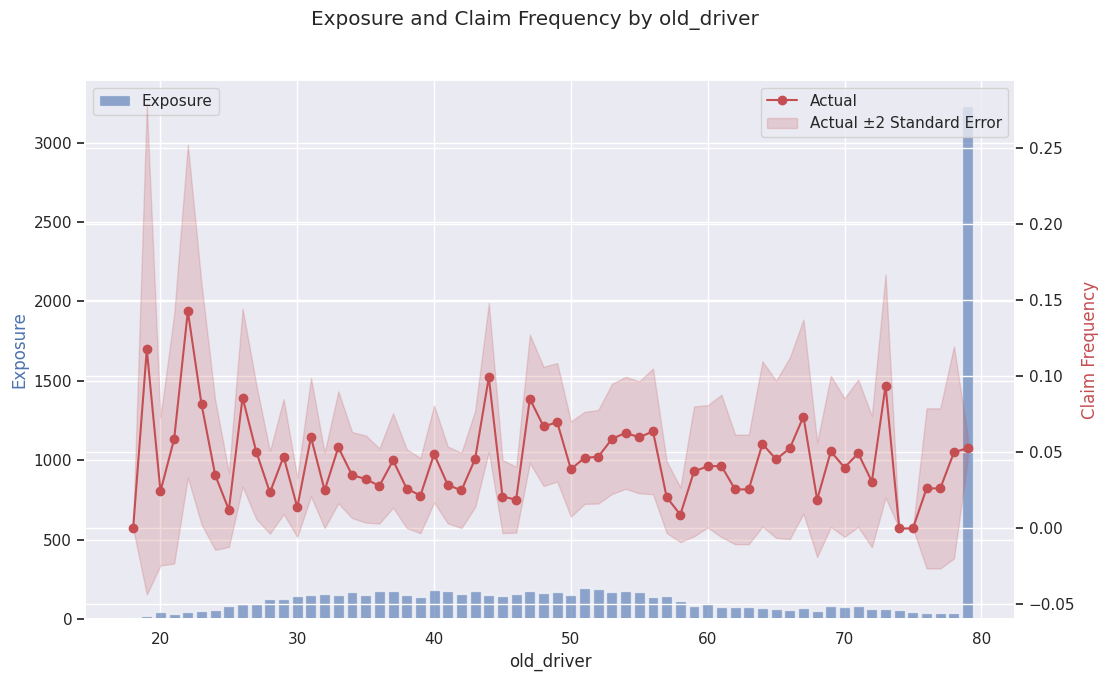

[18.0, 22.0, 25.0, 26.0, 28.0, 44.0, 45.0, 47.0, 50.0, 74.0, 79.0]


In [22]:
plotave(df,['old_driver'],WeightCol=None, recommendBanding=True, upper=79)

Rejected. As a market price determinant:

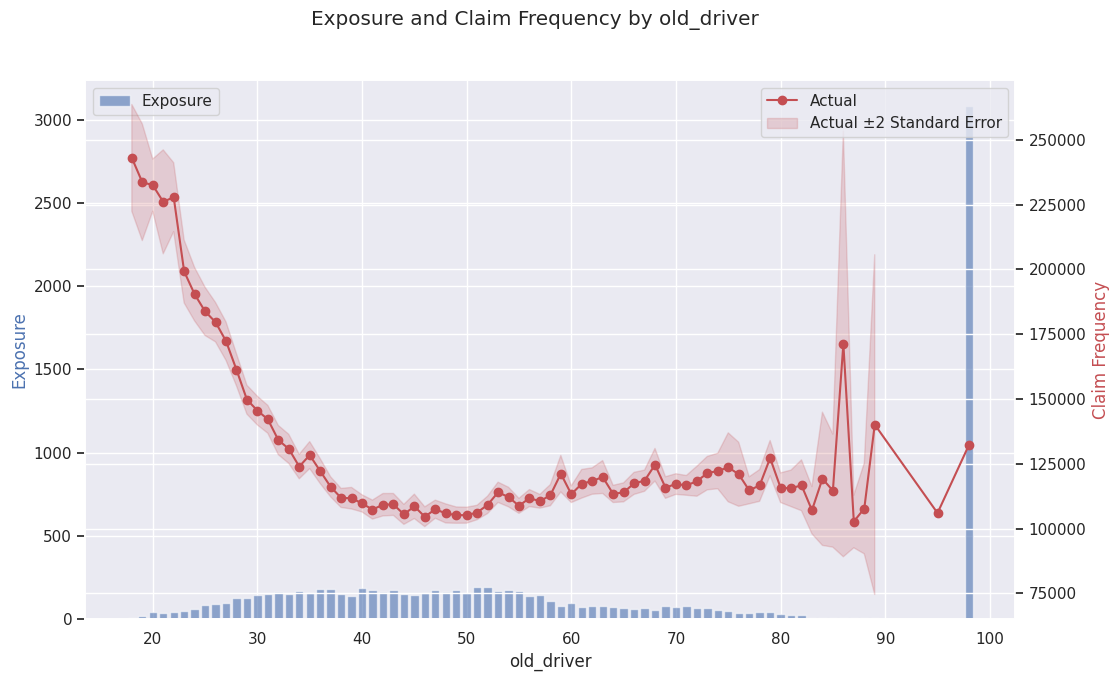

[18.0, 23.0, 25.0, 27.0, 28.0, 29.0, 31.0, 32.0, 34.0, 37.0, 38.0, 41.0, 53.0, 55.0, 58.0, 59.0, 60.0, 63.0, 64.0, 67.0, 79.0, 80.0, 87.0, 98.0]


In [23]:
plotave(df,['old_driver'],WeightCol=None,ValueCol='M', recommendBanding=True)

This is a very strong explanatory factor, so for price watch modeling, it warrants a large number of bins (up to 79).


In [24]:
#Kaggle Markdown is a pain, so it's better to use hash-marked code for textual comments
#Now, a tricky variable is coming: domestic
#It has too much range, so the exposure wouldn't be visible, so narrow bars should be plotted <<1 pixel width
#resetXaxis was made for another situation, but it can be handy here

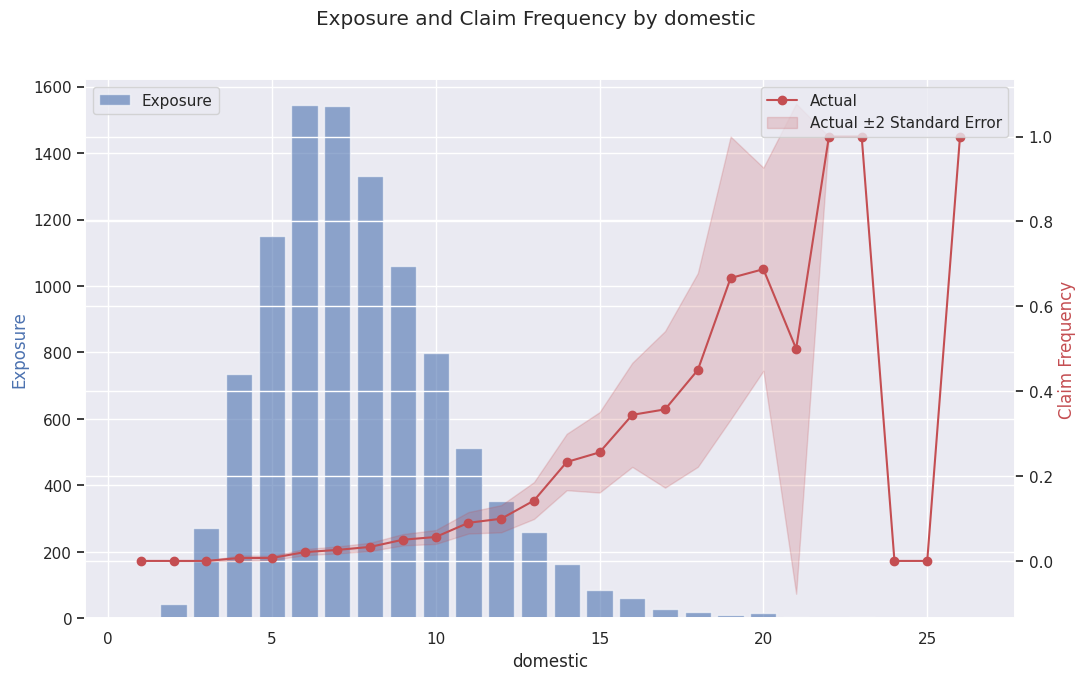

[0.0, 3000.0, 5000.0, 7000.0, 8000.0, 10000.0, 12000.0, 13000.0, 18000.0, 24000.0, 25000.0, 27000.0]
Original Value  0.0  3000.0  5000.0  7000.0  8000.0  10000.0  12000.0  13000.0  18000.0  24000.0  25000.0  27000.0
Rank            1.0     4.0     6.0     8.0     9.0     11.0     13.0     14.0     19.0     24.0     25.0     26.0


In [25]:
plotave(df,['domestic'],resetXaxis=True, recommendBanding=True)

In [26]:
#You can see the downside of resetXaxis here: the X-axis shows the rank instead of the actual values.
#This isn't a problem as long as autobanding looks reliable.
#If it doesn't, the table form can help manually adjust it.
#Actually, you can see on the chart, that 19 is the last reasonable split,
#You can look up that 19 means 18000.0
#And add the truncated list to our "bandings" named dictionary (below that EDA part)
#Let's see the same for market 
#Since we'll obviously face the same situation for foreign and odometer, do them after

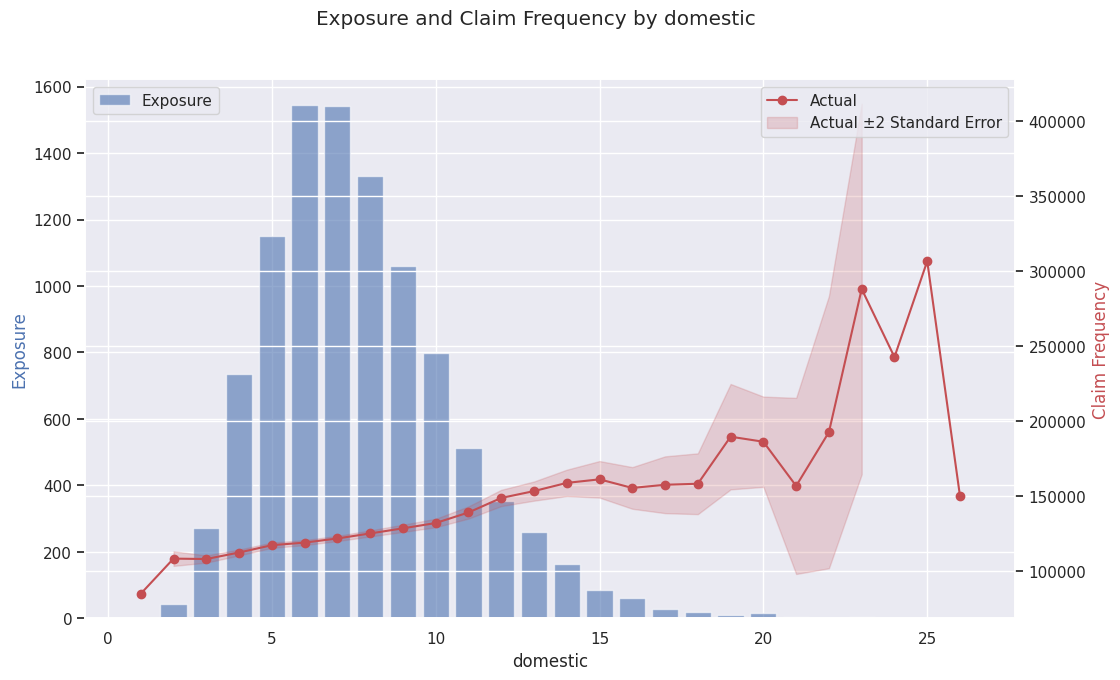

[0.0, 1000.0, 4000.0, 6000.0, 7000.0, 8000.0, 9000.0, 10000.0, 11000.0, 13000.0, 22000.0, 27000.0]
Original Value  0.0  1000.0  4000.0  6000.0  7000.0  8000.0  9000.0  10000.0  11000.0  13000.0  22000.0  27000.0
Rank            1.0     2.0     5.0     7.0     8.0     9.0    10.0     11.0     12.0     14.0     23.0     26.0


In [27]:
plotave(df,['domestic'],ValueCol='M',resetXaxis=True, recommendBanding=True)

In [28]:
#Cutting from 22000.0 is obliviously useless. Remember, from 18000.0 we also wont apply banding, as shown below:
#Original Value  0.0  3000.0  5000.0  7000.0  8000.0  10000.0  12000.0  13000.0  18000.0---------------------------
#Rank            1.0     4.0     6.0     8.0     9.0     11.0     13.0     14.0     19.0---------------------------
#Original Value  0.0  1000.0  4000.0  6000.0  7000.0   8000.0   9000.0  10000.0  11000.0  13000.0------------------
#Rank            1.0     2.0     5.0     7.0     8.0      9.0     10.0     11.0     12.0     14.0------------------
#Now here we have to merge the two bandings due to data governance decision
#It's a bit softie, but lets try to simply union the two banding
#Move on to foreign

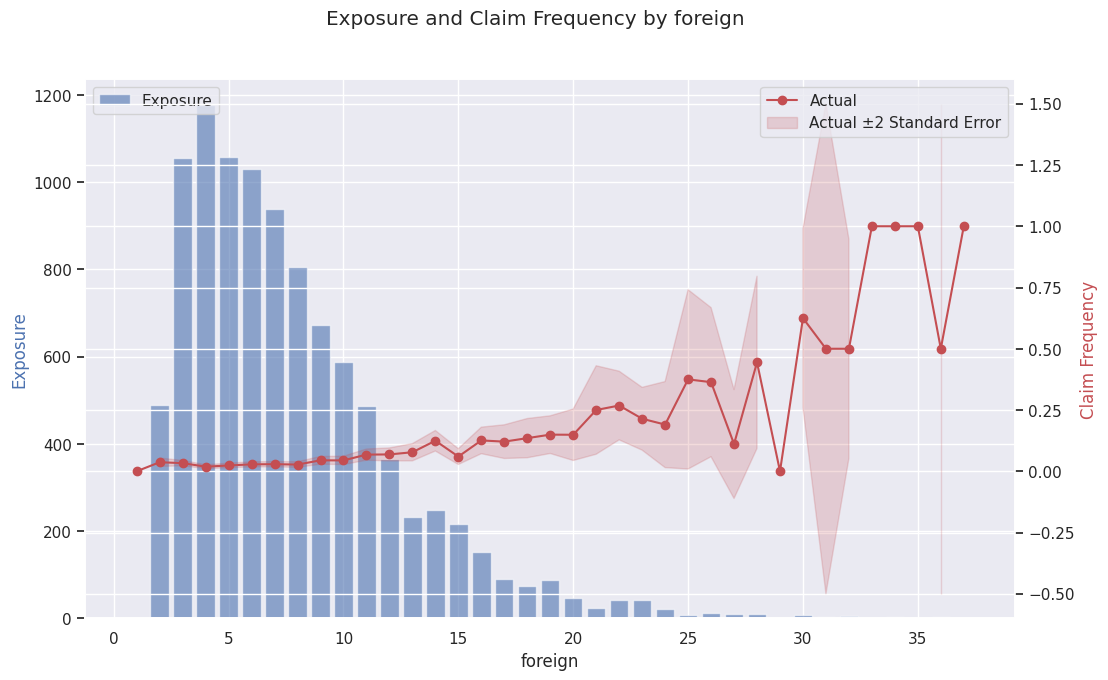

[0.0, 500.0, 1500.0, 4000.0, 5000.0, 6500.0, 7000.0, 7500.0, 10500.0, 14000.0, 14500.0, 16000.0, 17000.0, 20500.0]
Original Value  0.0  500.0  1500.0  4000.0  5000.0  6500.0  7000.0  7500.0  10500.0  14000.0  14500.0  16000.0  17000.0  20500.0
Rank            1.0    2.0     4.0     9.0    11.0    14.0    15.0    16.0     22.0     29.0     30.0     33.0     35.0     37.0


In [29]:
plotave(df,'foreign',resetXaxis=True,recommendBanding=True)

In [30]:
#Here we can see typical mistakes of the auto-banding:
#0 has virtually no exposure, needn't to be split
#15 isn't look like an actually different category
#The more reasonable banding would have a single category >20
#That "20" need to be look up manually (9500 actually)

In [31]:
plotave(df,'foreign',resetXaxis=True,recommendBanding=True, lower=500, upper=9500)

[500.0, 1500.0, 4000.0, 5000.0, 6500.0, 7000.0, 7500.0, 9500.0]
Original Value  500.0  1500.0  4000.0  5000.0  6500.0  7000.0  7500.0  9500.0
Rank              1.0     3.0     8.0    10.0    13.0    14.0    15.0    19.0


In [32]:
#looks better :)
#how about market value?

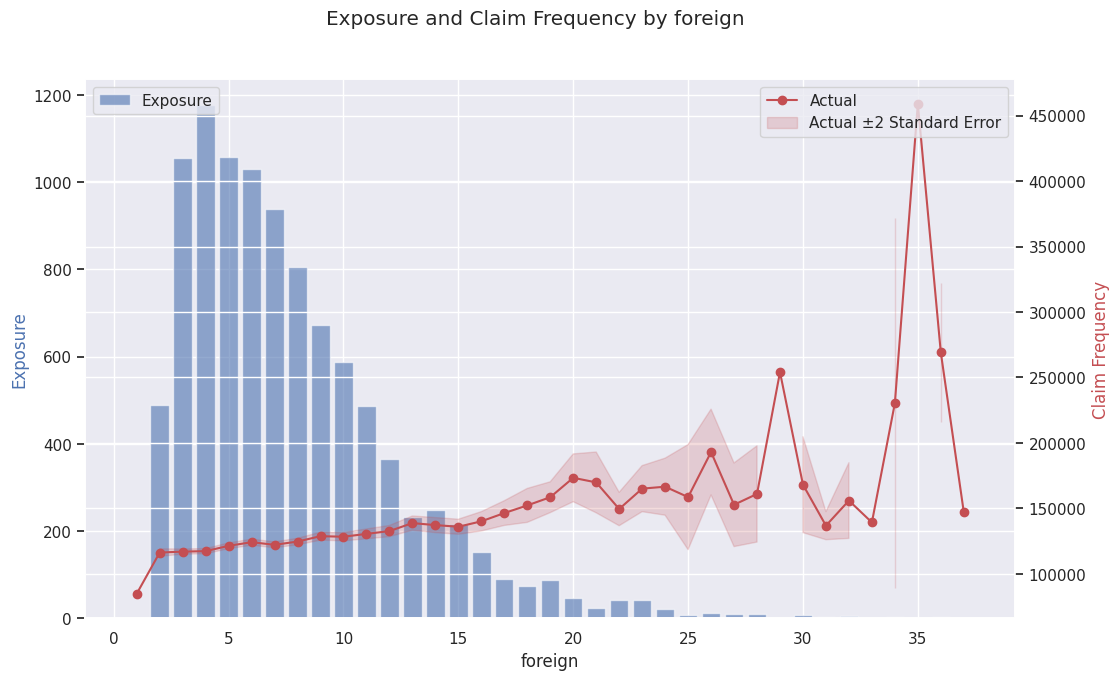

[0.0, 500.0, 2000.0, 2500.0, 4000.0, 6000.0, 8500.0, 9500.0, 10500.0, 12500.0, 13000.0, 14000.0, 14500.0, 17000.0, 18000.0, 20500.0]
Original Value  0.0  500.0  2000.0  2500.0  4000.0  6000.0  8500.0  9500.0  10500.0  12500.0  13000.0  14000.0  14500.0  17000.0  18000.0  20500.0
Rank            1.0    2.0     5.0     6.0     9.0    13.0    18.0    20.0     22.0     26.0     27.0     29.0     30.0     35.0     36.0     37.0


In [33]:
plotave(df,'foreign',ValueCol='M',resetXaxis=True,recommendBanding=True)

In [34]:
#There is still no mercy with the 1 (one) observed foreign=1 data "group"
#Also, the aforementioned >20 should be applied

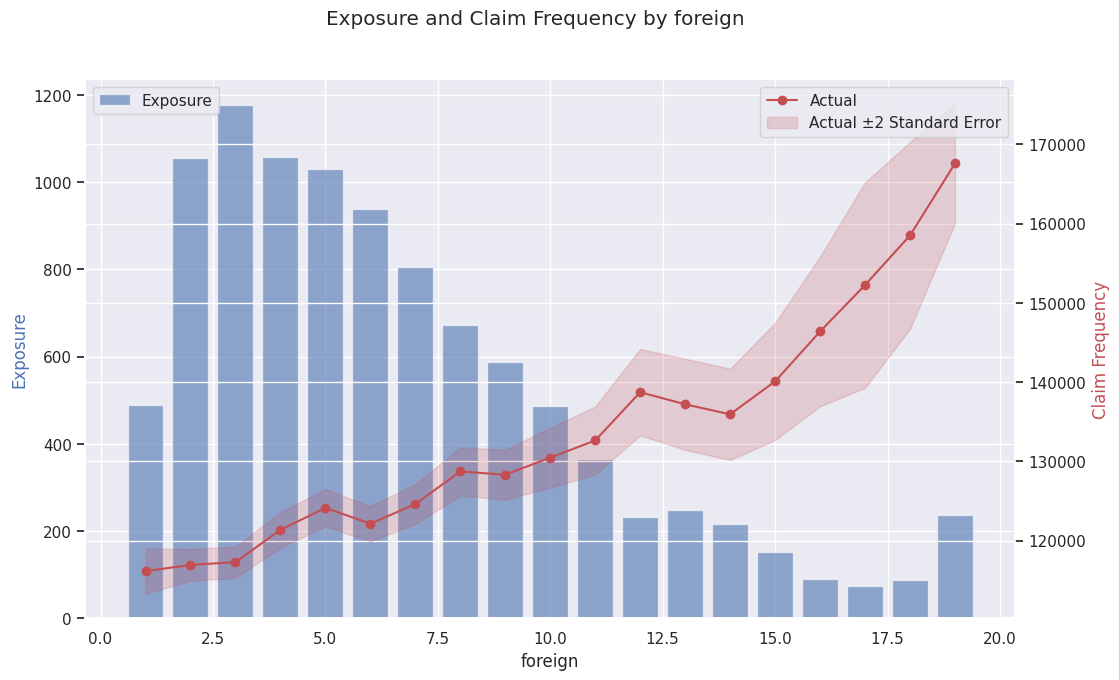

[500.0, 2000.0, 2500.0, 4000.0, 6000.0, 8500.0, 9500.0]
Original Value  500.0  2000.0  2500.0  4000.0  6000.0  8500.0  9500.0
Rank              1.0     4.0     5.0     8.0    12.0    17.0    19.0


In [35]:
plotave(df,'foreign',ValueCol='M',resetXaxis=True,recommendBanding=True, lower=500, upper=9500)

In [36]:
#Manual merging:
#Original Value  500.0  1500.0  4000.0  5000.0  6500.0  7000.0  7500.0  9500.0
#Rank              1.0     3.0     8.0    10.0    13.0    14.0    15.0    19.0
#Original Value  500.0  2000.0  2500.0  4000.0  6000.0  8500.0  9500.0
#Rank              1.0     4.0     5.0     8.0    12.0    17.0    19.0
#Don't forget 500.0 is actually containing that 1 piece of 0.0

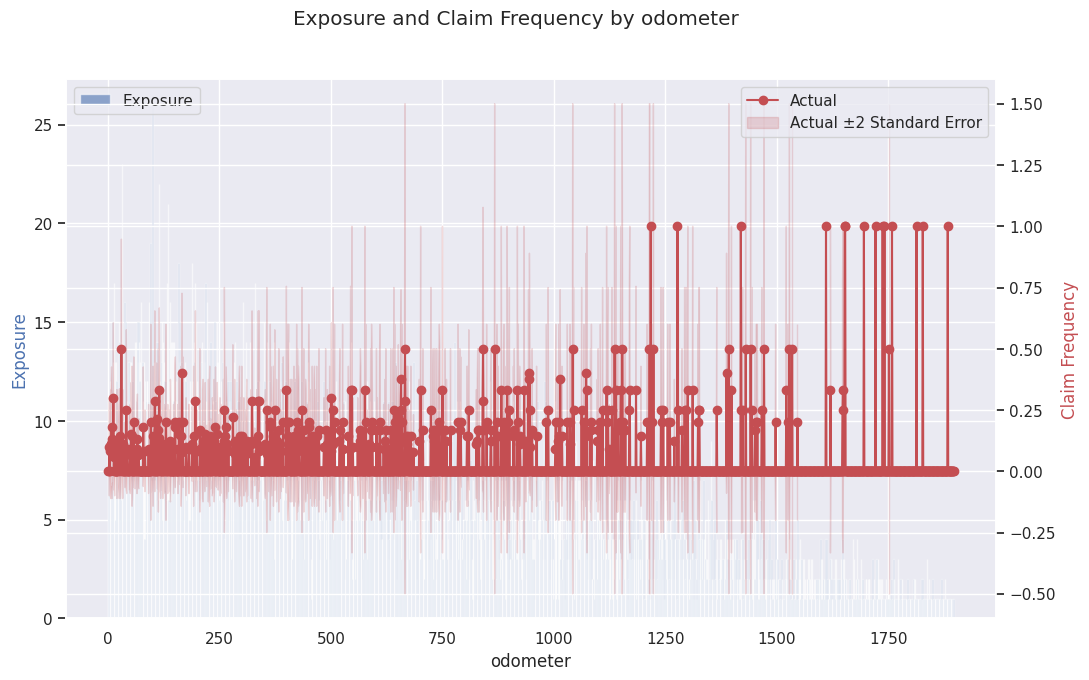

[100.0, 3000.0, 3100.0, 16600.0, 16700.0, 65700.0, 65800.0, 94300.0, 94400.0, 101400.0, 101500.0, 121700.0, 121800.0, 122600.0, 122700.0, 124800.0, 125000.0, 127500.0, 127800.0, 127900.0, 128000.0, 143500.0, 143600.0, 166600.0, 166900.0, 174600.0, 174700.0, 175000.0, 181300.0, 181400.0, 181700.0, 181800.0, 182600.0, 182900.0, 183000.0, 183200.0, 183700.0, 183900.0, 184400.0, 184600.0, 184700.0, 184900.0, 185200.0, 185400.0, 185600.0, 186000.0, 186300.0, 186700.0, 186900.0, 189800.0, 190000.0, 190100.0, 190200.0, 190500.0, 190700.0, 190800.0, 191100.0, 191500.0, 191800.0, 192400.0, 192500.0, 193300.0, 193600.0, 193800.0, 194500.0, 194800.0, 195300.0, 195600.0, 195700.0, 196400.0, 196800.0, 196900.0, 197200.0, 197300.0, 197400.0, 197600.0, 197900.0, 199200.0, 199400.0, 200200.0, 200300.0, 200600.0, 201000.0, 201400.0, 202700.0, 202900.0, 203000.0, 203400.0, 203800.0, 203900.0, 204100.0, 204800.0, 205000.0, 205400.0, 206000.0, 207800.0, 208100.0, 208400.0, 208900.0, 209300.0, 209800.0, 20

In [37]:
plotave(df,'odometer',resetXaxis=True,recommendBanding=True)

In [38]:
#It's horrible. I blindely accept odometer, and reproceed with readable data
#For this I run bandings cell below the EDA, you can think of:

In [39]:
bandings = {'odometer':[100.0, 3000.0, 3100.0, 16600.0, 16700.0, 65700.0, 65800.0, 94300.0, 94400.0, 101400.0, 101500.0, 121700.0, 121800.0, 122600.0, 122700.0, 124800.0, 125000.0, 127500.0, 127800.0, 127900.0, 128000.0, 143500.0, 143600.0, 166600.0, 166900.0, 174600.0, 174700.0, 175000.0, 181300.0, 181400.0, 181700.0, 181800.0, 182600.0, 182900.0, 183000.0, 183200.0, 183700.0, 183900.0, 184400.0, 184600.0, 184700.0, 184900.0, 185200.0, 185400.0, 185600.0, 186000.0, 186300.0, 186700.0, 186900.0, 189800.0, 190000.0, 190100.0, 190200.0, 190500.0, 190700.0, 190800.0, 191100.0, 191500.0, 191800.0, 192400.0, 192500.0, 193300.0, 193600.0, 193800.0, 194500.0, 194800.0, 195300.0, 195600.0, 195700.0, 196400.0, 196800.0, 196900.0, 197200.0, 197300.0, 197400.0, 197600.0, 197900.0, 199200.0, 199400.0, 200200.0, 200300.0, 200600.0, 201000.0, 201400.0, 202700.0, 202900.0, 203000.0, 203400.0, 203800.0, 203900.0, 204100.0, 204800.0, 205000.0, 205400.0, 206000.0, 207800.0, 208100.0, 208400.0, 208900.0, 209300.0, 209800.0, 209900.0, 210100.0, 210700.0, 210800.0, 211000.0, 211100.0, 211900.0, 212400.0, 212800.0, 213200.0, 213900.0, 214100.0, 214700.0, 215000.0, 215300.0, 215900.0, 216000.0, 216500.0, 216700.0, 216800.0, 217400.0, 218400.0, 219600.0, 220000.0, 220100.0, 220400.0, 220500.0, 220700.0, 220900.0, 221100.0, 221200.0, 221800.0, 222300.0, 222500.0, 222700.0, 224500.0, 224700.0, 225000.0, 225300.0, 225800.0, 225900.0, 227400.0, 228200.0, 228300.0, 229100.0, 229800.0, 230000.0, 230100.0, 230500.0, 230700.0, 231800.0, 233600.0, 234000.0, 234200.0, 237000.0, 239100.0, 241100.0, 242200.0, 242800.0, 243400.0, 243900.0, 246600.0, 246800.0, 247800.0, 249200.0, 249700.0, 249900.0, 255100.0, 256200.0, 256800.0, 260000.0, 260800.0, 261800.0, 262700.0, 268600.0, 270400.0, 284300.0, 285000.0, 288900.0, 290500.0, 294100.0, 306400.0, 308700.0, 309100.0, 332600.0, 334400.0, 407800.0]}
df = add_banding_columns(df, bandings)

In [40]:
#Note the _ prefix

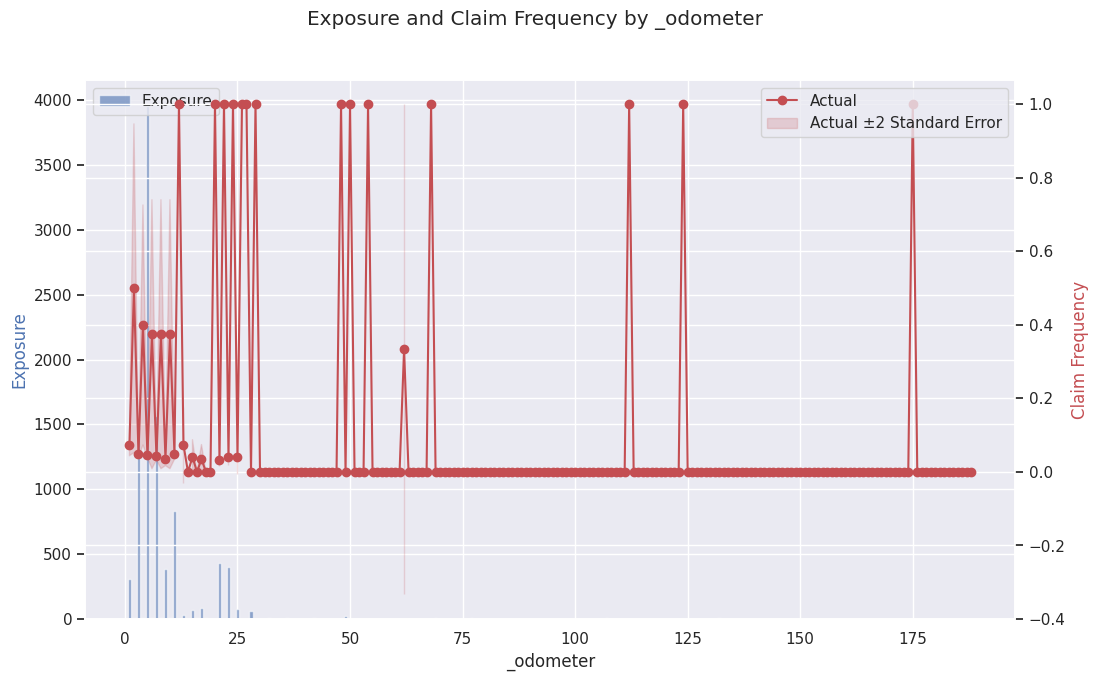

[100.0, 65800.0, 121700.0, 121800.0, 127900.0, 128000.0, 143500.0, 143600.0, 166600.0, 166900.0, 174600.0, 174700.0, 175000.0, 181300.0, 181400.0, 181700.0, 182600.0, 182900.0, 183700.0, 183900.0, 184400.0, 184600.0, 184700.0, 185200.0, 185600.0, 186000.0, 186300.0, 186700.0, 186900.0, 189800.0, 190000.0, 190100.0, 190200.0, 190500.0, 190700.0, 191100.0, 191500.0, 191800.0, 192400.0, 192500.0, 193600.0, 193800.0, 194500.0, 194800.0, 195600.0, 195700.0, 213900.0, 214100.0, 214700.0, 215000.0, 215300.0, 215900.0, 216000.0, 216500.0, 216700.0, 216800.0, 219600.0, 220000.0, 220100.0, 220400.0, 220500.0, 220700.0, 220900.0, 221100.0, 221800.0, 222300.0, 222500.0, 224500.0, 224700.0, 225000.0, 225300.0, 225800.0, 225900.0, 228200.0, 228300.0, 229100.0, 229800.0, 230000.0, 230100.0, 230500.0, 230700.0, 231800.0, 233600.0, 234000.0, 234200.0, 237000.0, 239100.0, 241100.0, 242200.0, 242800.0, 243400.0, 246600.0, 246800.0, 247800.0, 249200.0, 249700.0, 249900.0, 256200.0, 256800.0, 260000.0, 260

In [41]:
plotave(df,'_odometer',resetXaxis=True,recommendBanding=True)

In [42]:
#This is way tooooo unique feature. Could we try some polinom?

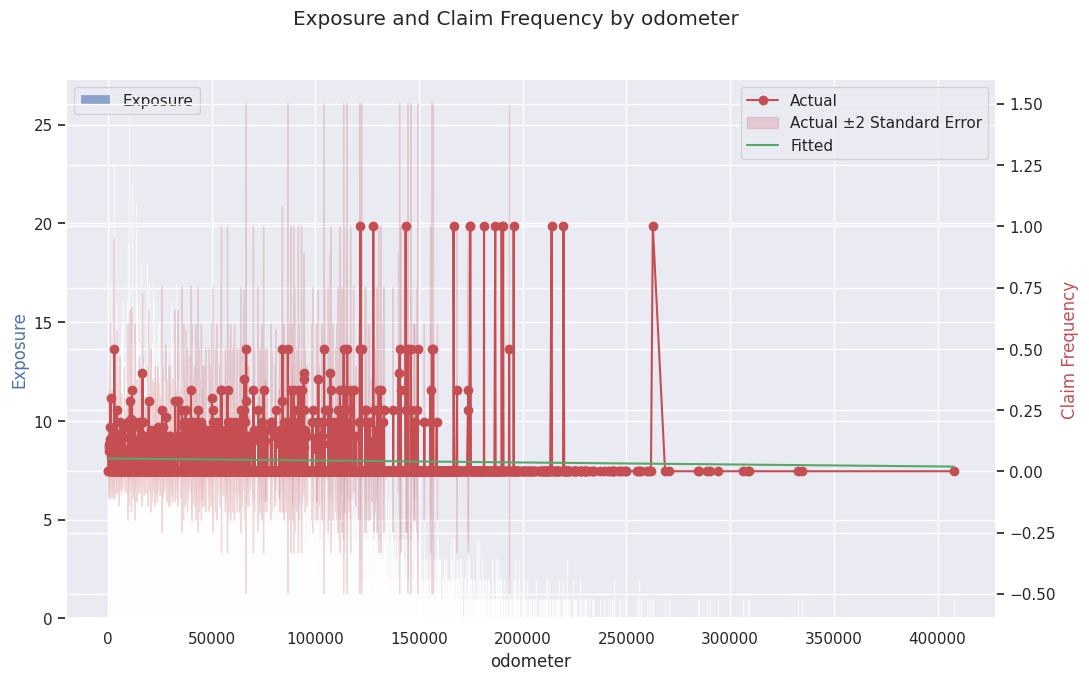

[100.0, 3000.0, 3100.0, 16600.0, 16700.0, 65700.0, 65800.0, 94300.0, 94400.0, 101400.0, 101500.0, 121700.0, 121800.0, 122600.0, 122700.0, 124800.0, 125000.0, 127500.0, 127800.0, 127900.0, 128000.0, 143500.0, 143600.0, 166600.0, 166900.0, 174600.0, 174700.0, 175000.0, 181300.0, 181400.0, 181700.0, 181800.0, 182600.0, 182900.0, 183000.0, 183200.0, 183700.0, 183900.0, 184400.0, 184600.0, 184700.0, 184900.0, 185200.0, 185400.0, 185600.0, 186000.0, 186300.0, 186700.0, 186900.0, 189800.0, 190000.0, 190100.0, 190200.0, 190500.0, 190700.0, 190800.0, 191100.0, 191500.0, 191800.0, 192400.0, 192500.0, 193300.0, 193600.0, 193800.0, 194500.0, 194800.0, 195300.0, 195600.0, 195700.0, 196400.0, 196800.0, 196900.0, 197200.0, 197300.0, 197400.0, 197600.0, 197900.0, 199200.0, 199400.0, 200200.0, 200300.0, 200600.0, 201000.0, 201400.0, 202700.0, 202900.0, 203000.0, 203400.0, 203800.0, 203900.0, 204100.0, 204800.0, 205000.0, 205400.0, 206000.0, 207800.0, 208100.0, 208400.0, 208900.0, 209300.0, 209800.0, 20

In [43]:
plotave(df,'odometer',polinomDegree=1,recommendBanding=True)

In [44]:
#It would be a bit more spectacular without the +/-2*Standard Errors

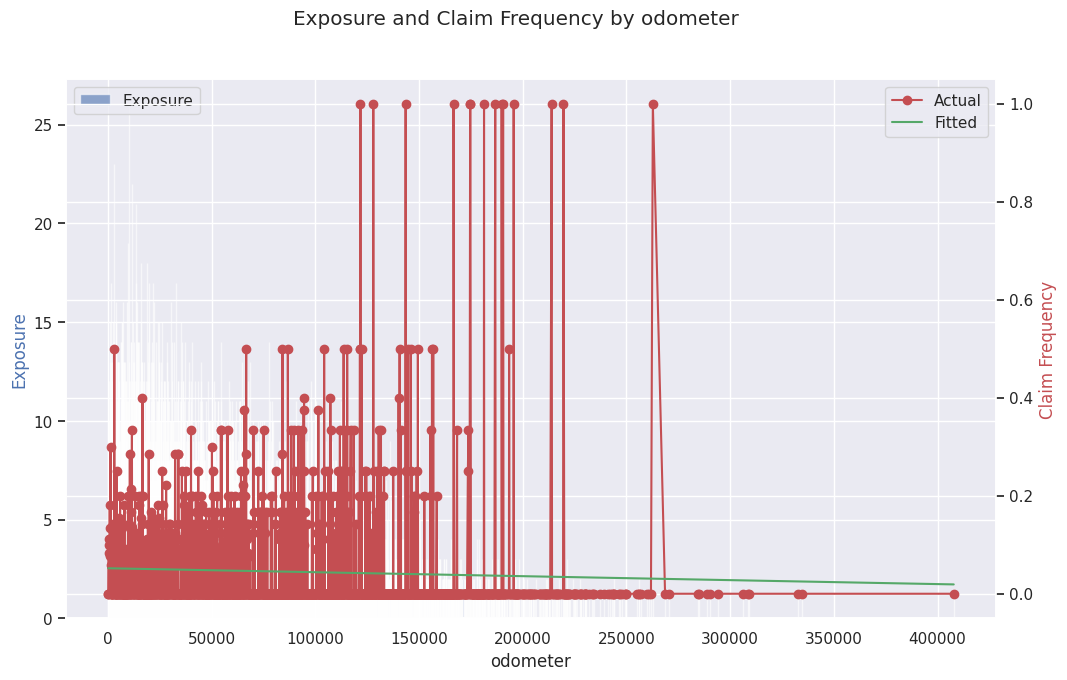

[100.0, 3000.0, 3100.0, 16600.0, 16700.0, 65700.0, 65800.0, 94300.0, 94400.0, 101400.0, 101500.0, 121700.0, 121800.0, 122600.0, 122700.0, 124800.0, 125000.0, 127500.0, 127800.0, 127900.0, 128000.0, 143500.0, 143600.0, 166600.0, 166900.0, 174600.0, 174700.0, 175000.0, 181300.0, 181400.0, 181700.0, 181800.0, 182600.0, 182900.0, 183000.0, 183200.0, 183700.0, 183900.0, 184400.0, 184600.0, 184700.0, 184900.0, 185200.0, 185400.0, 185600.0, 186000.0, 186300.0, 186700.0, 186900.0, 189800.0, 190000.0, 190100.0, 190200.0, 190500.0, 190700.0, 190800.0, 191100.0, 191500.0, 191800.0, 192400.0, 192500.0, 193300.0, 193600.0, 193800.0, 194500.0, 194800.0, 195300.0, 195600.0, 195700.0, 196400.0, 196800.0, 196900.0, 197200.0, 197300.0, 197400.0, 197600.0, 197900.0, 199200.0, 199400.0, 200200.0, 200300.0, 200600.0, 201000.0, 201400.0, 202700.0, 202900.0, 203000.0, 203400.0, 203800.0, 203900.0, 204100.0, 204800.0, 205000.0, 205400.0, 206000.0, 207800.0, 208100.0, 208400.0, 208900.0, 209300.0, 209800.0, 20

In [45]:
plotave(df,'odometer',polinomDegree=1,recommendBanding=True, show2SE=False)

In [46]:
#Let's see a cumulative sum instead

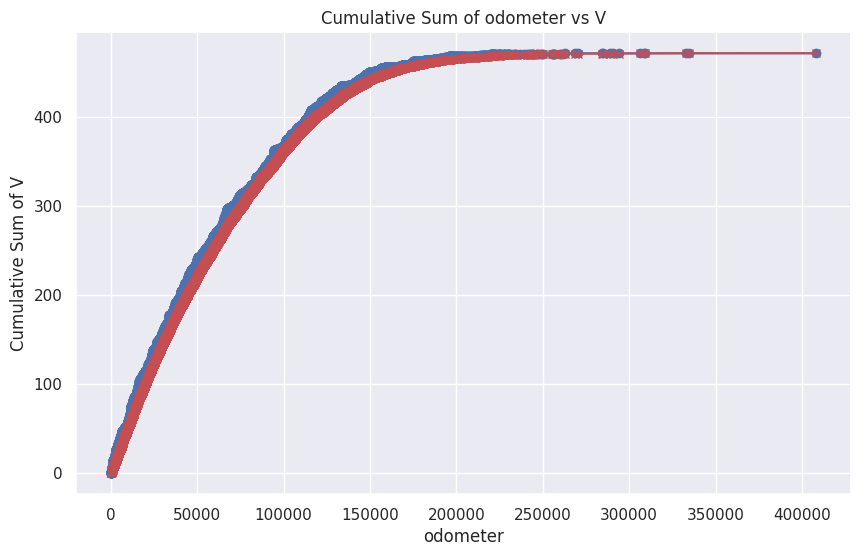

In [47]:
plot_cumulative_sum(df,'odometer')

<ipython-input-1-13d234fad6dc>:119: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result[GroupByCol] = result.groupby('bins')[GroupByCol].transform('min')


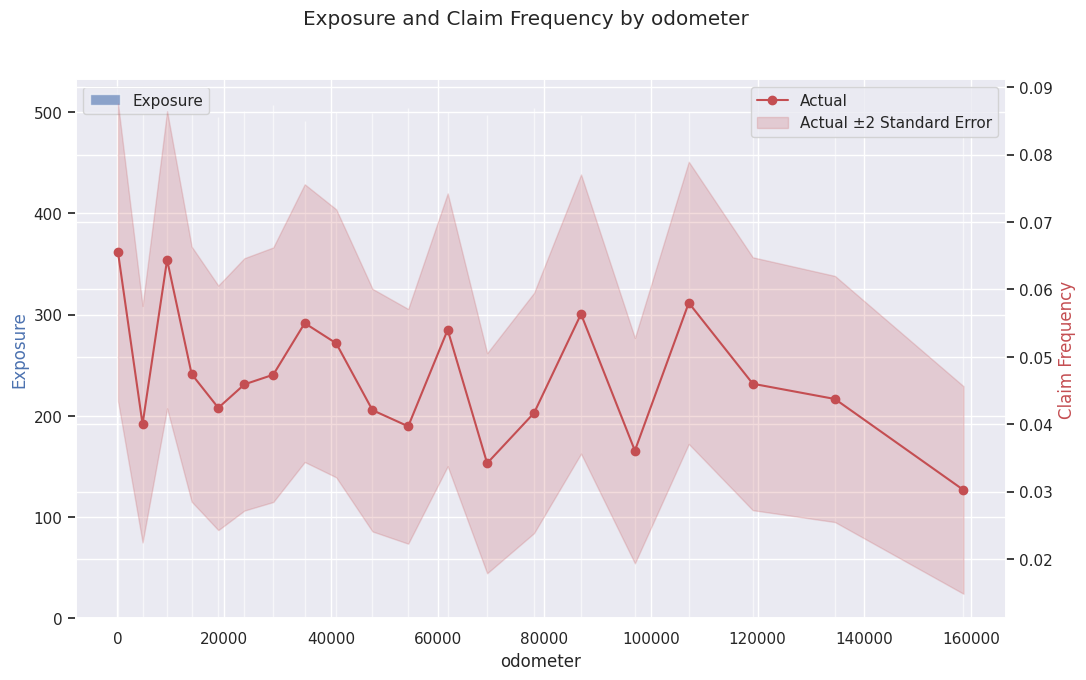

In [48]:
plotave(df,'odometer',nbins=20)

In [49]:
#Odometer reading is completely independent of risk
#What about market price?

In [50]:
plotave(df,'odometer',ValueCol='M',nbins=20)

<ipython-input-1-13d234fad6dc>:119: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result[GroupByCol] = result.groupby('bins')[GroupByCol].transform('min')


In [51]:
#Odometer should be dropped in the banding part
#also _odometer, created during EDA

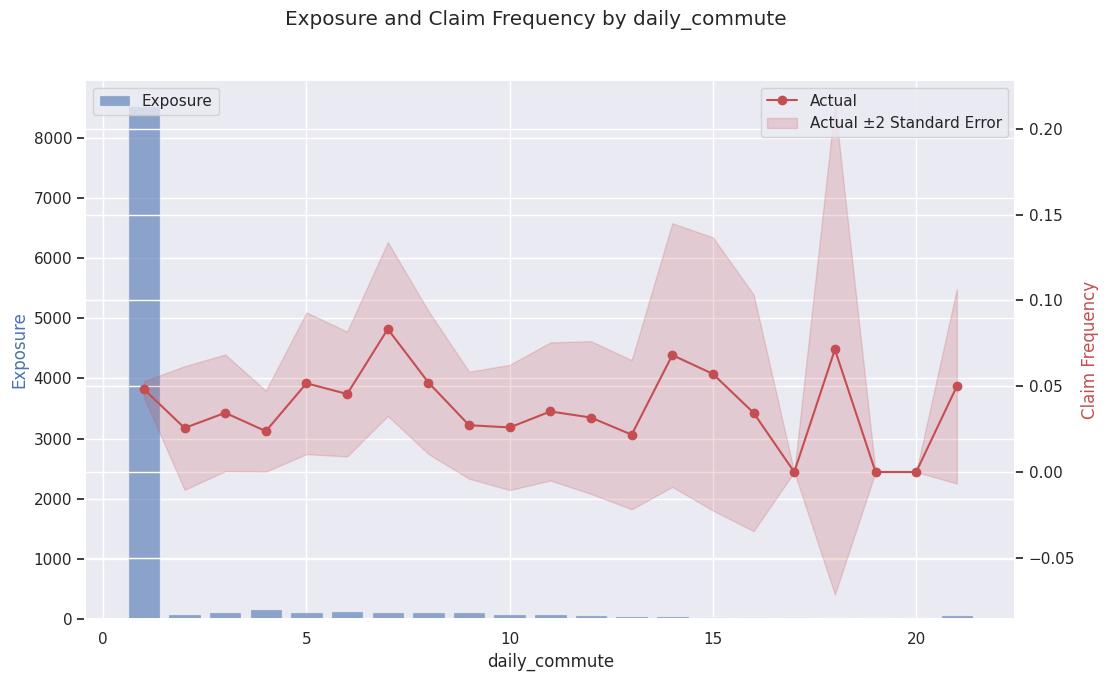

[0.0, 30.0, 60.0, 80.0]
Original Value  0.0  30.0  60.0  80.0
Rank            1.0   4.0   7.0   9.0


In [52]:
plotave(df,'daily_commute',resetXaxis=True,recommendBanding=True)

In [53]:
#resetXaxis just makes it looking better but still useless

In [54]:
plotave(df,'daily_commute',ValueCol='M',resetXaxis=True,recommendBanding=True)

[0.0, 120.0, 130.0, 150.0, 160.0]
Original Value  0.0  120.0  130.0  150.0  160.0
Rank            1.0   13.0   14.0   16.0   17.0


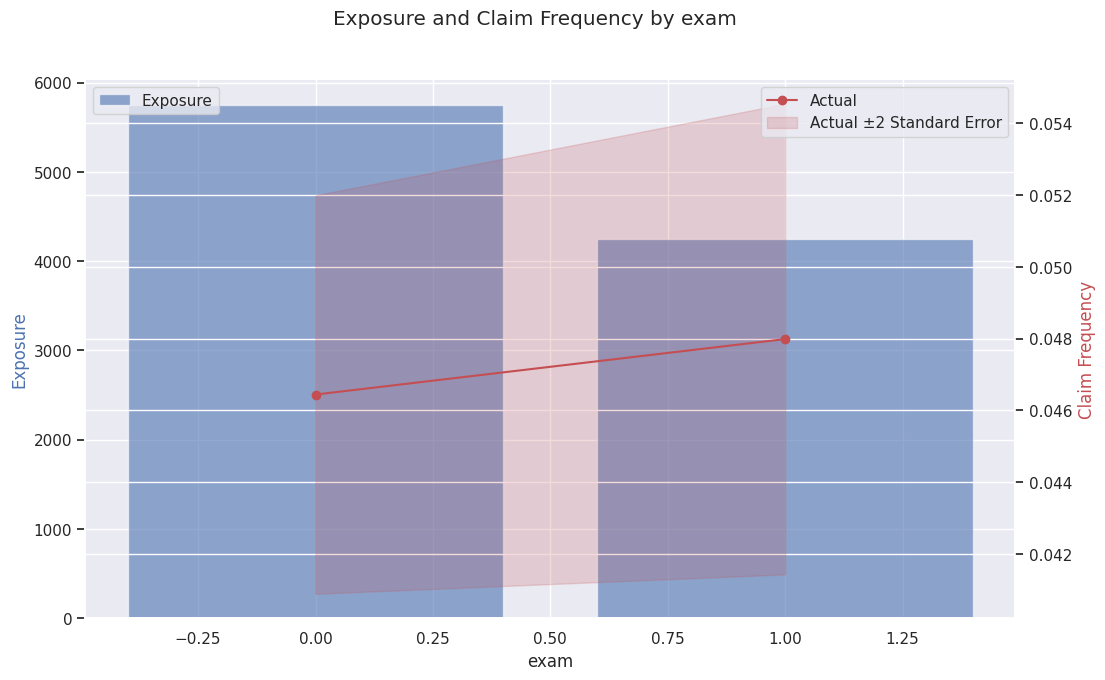

[0.0]


In [55]:
plotave(df,'exam',recommendBanding=True)

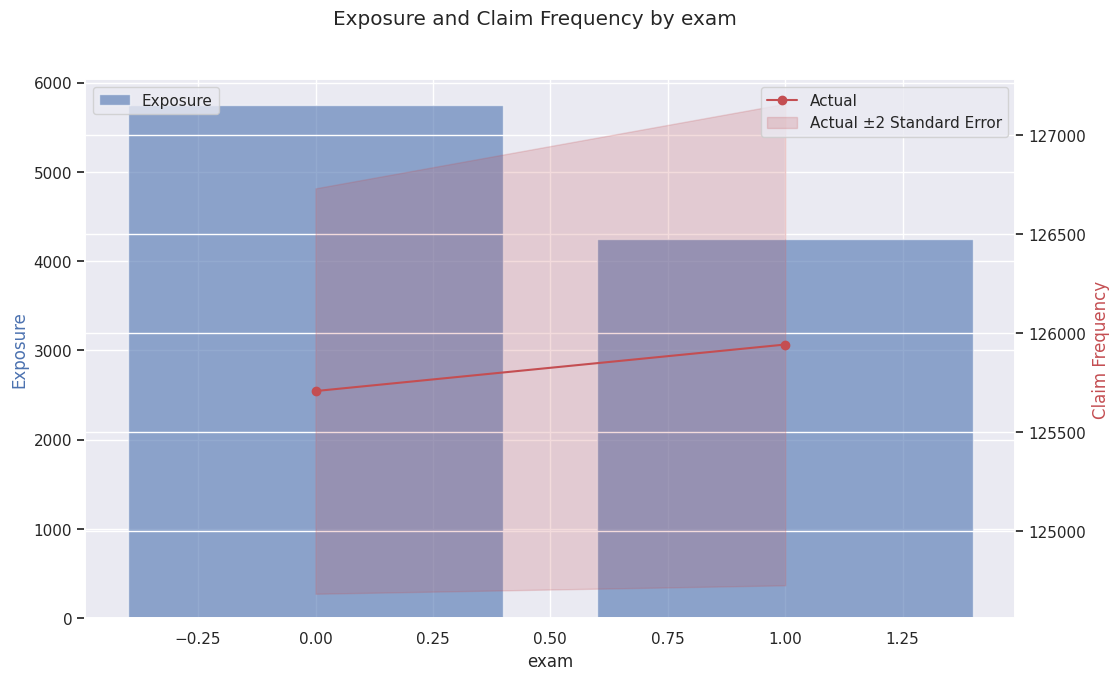

[0.0]


In [56]:
plotave(df,'exam',ValueCol='M',recommendBanding=True)

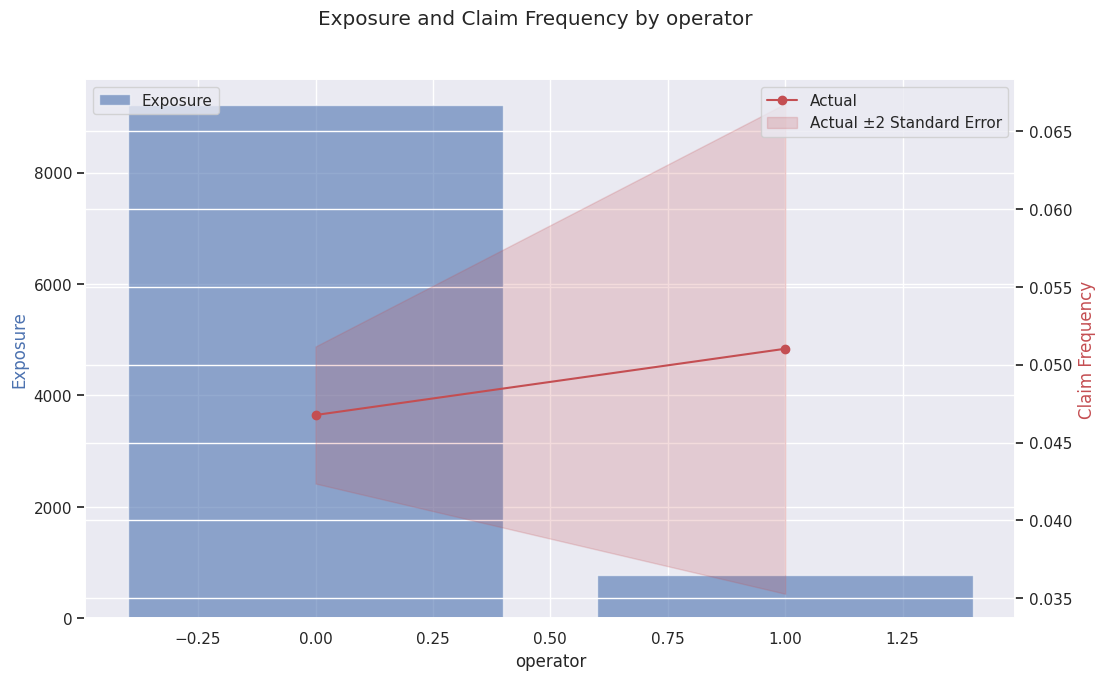

[0.0]


In [57]:
plotave(df,'operator',recommendBanding=True)

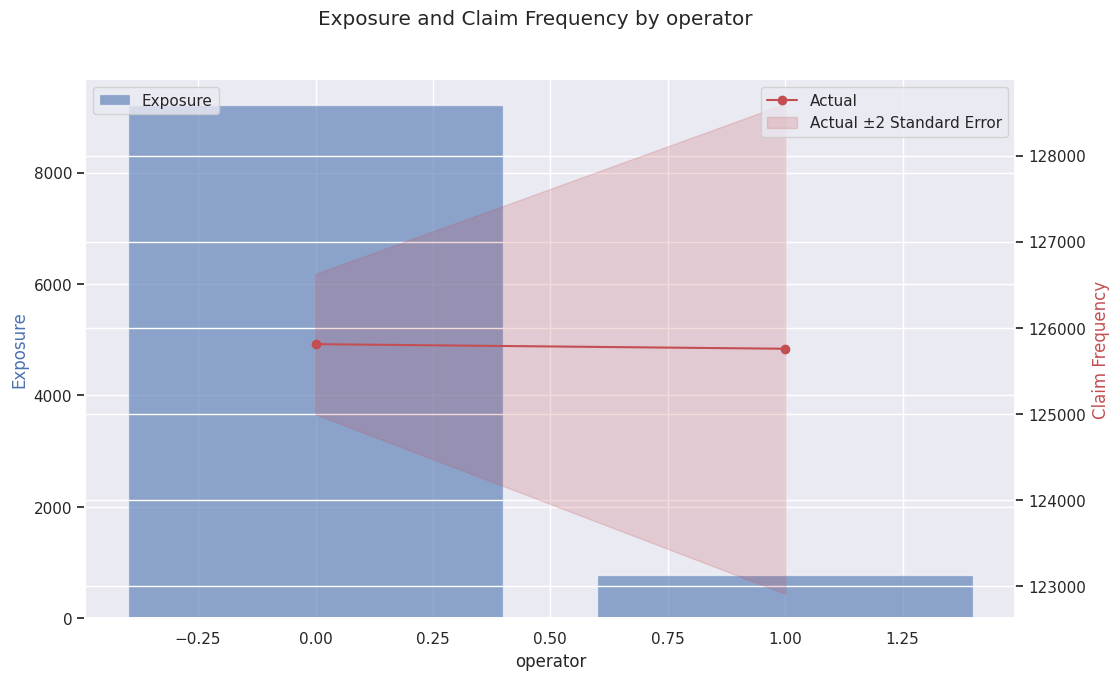

[0.0]


In [58]:
plotave(df,'operator',ValueCol='M',recommendBanding=True)

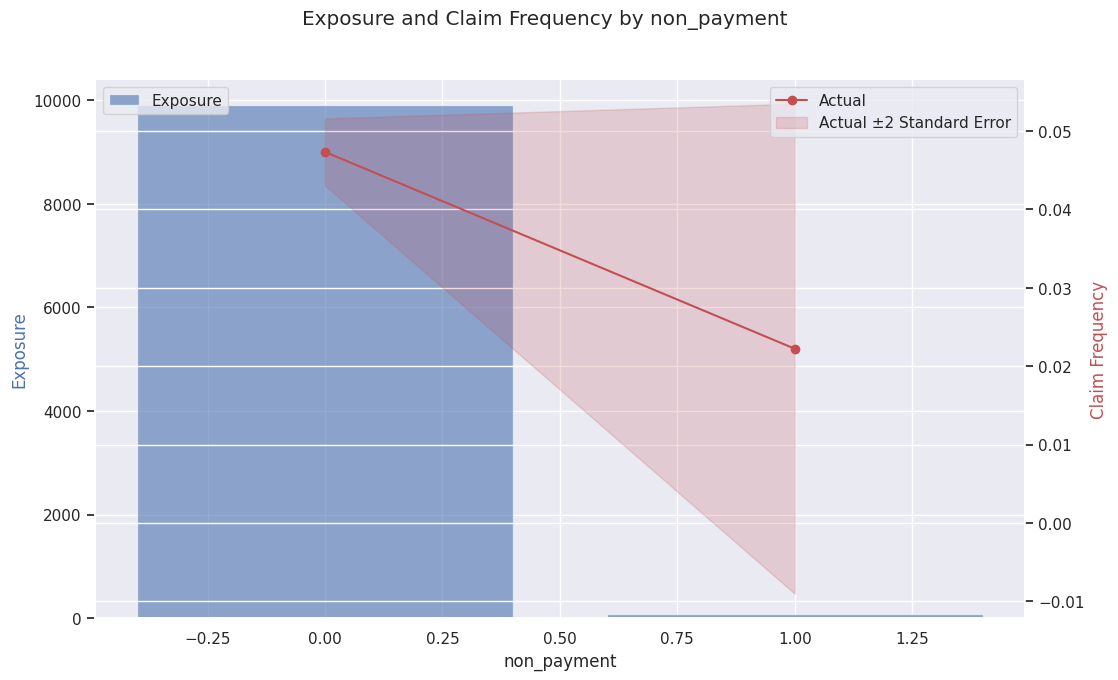

[0.0]


In [59]:
plotave(df,'non_payment',recommendBanding=True)

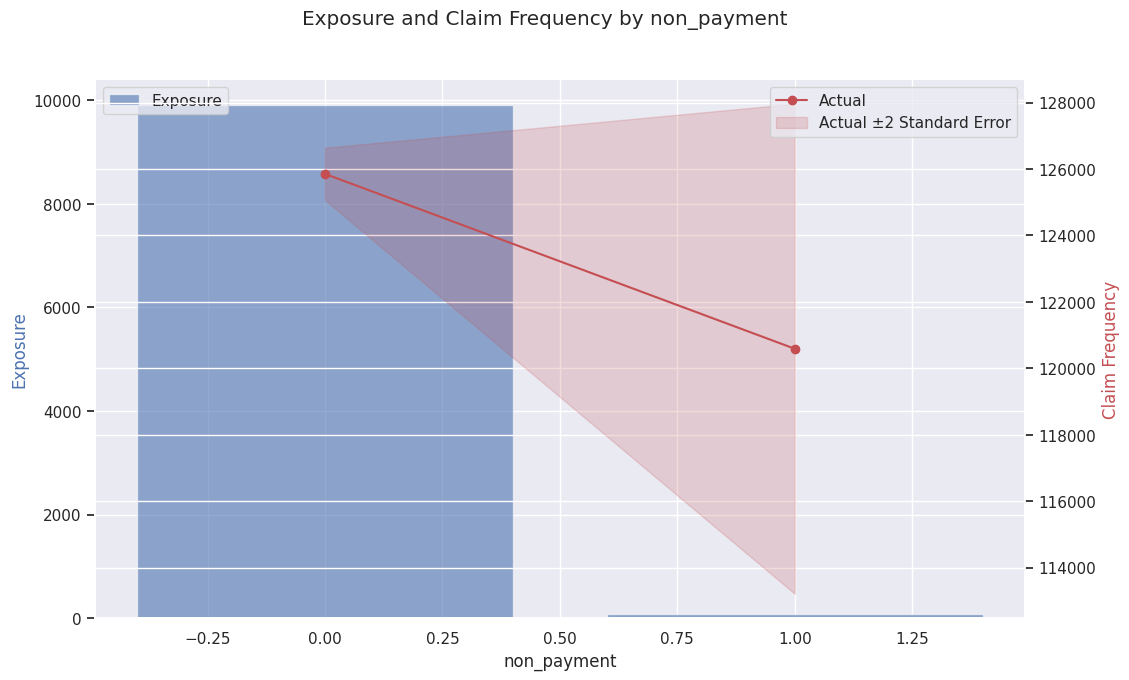

[0.0]


In [60]:
plotave(df,'non_payment',ValueCol='M',recommendBanding=True)

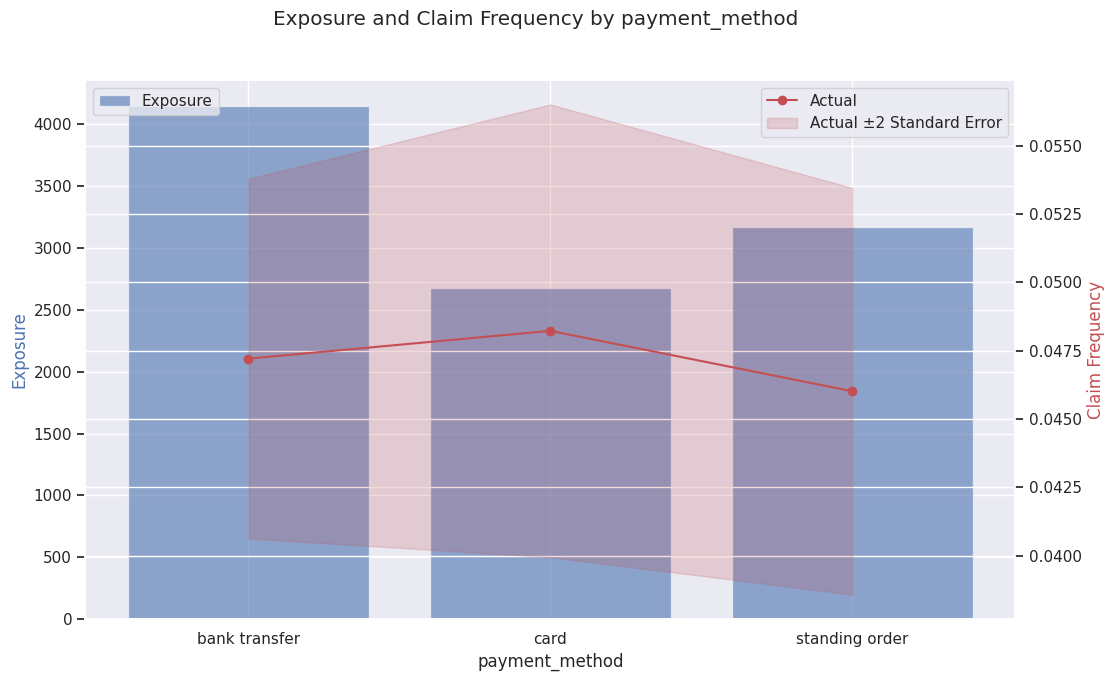

['bank transfer']


In [61]:
plotave(df,'payment_method',recommendBanding=True)

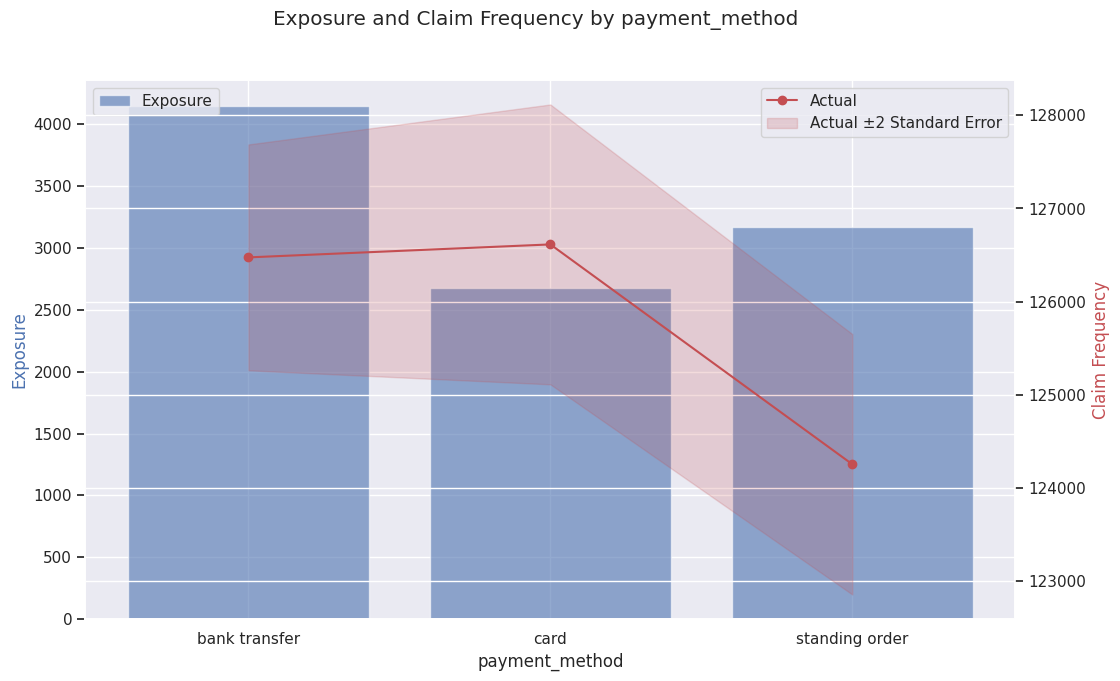

['bank transfer', 'standing order']


In [62]:
plotave(df,'payment_method',ValueCol='M',recommendBanding=True)

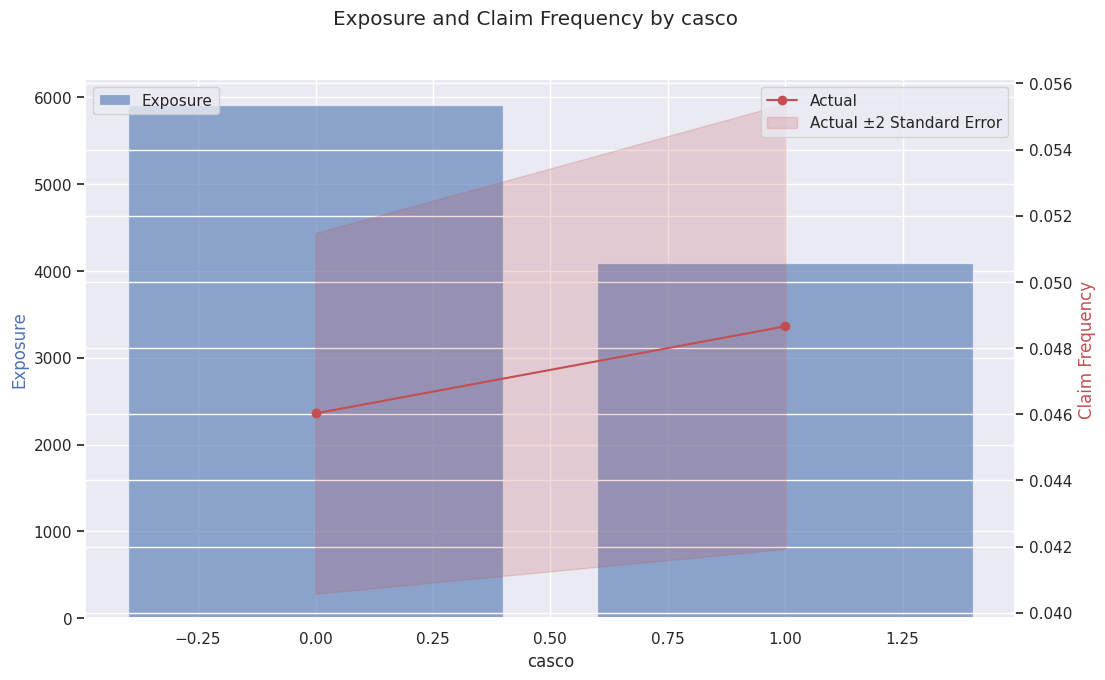

[0.0]


In [63]:
plotave(df,'casco',recommendBanding=True)

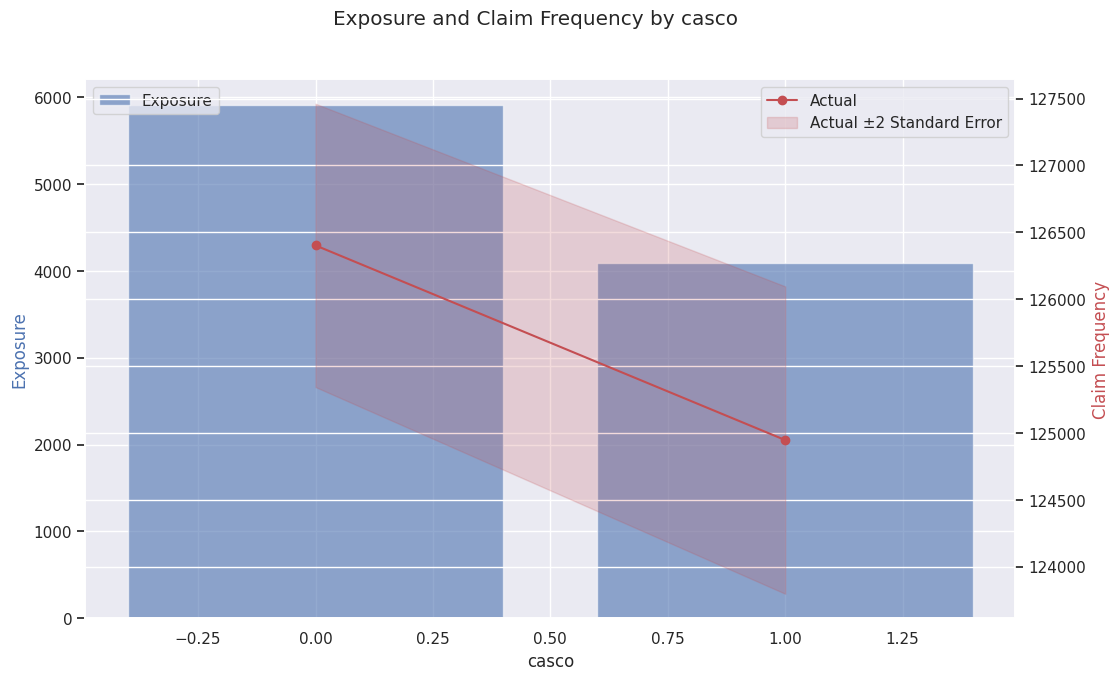

[0.0, 1.0]


In [64]:
plotave(df,'casco',ValueCol='M',recommendBanding=True)

In [65]:
plotave(df,'is_retired',ValueCol='M',recommendBanding=True)

[0.0, 1.0]


In [66]:
plotave(df,'is_retired',ValueCol='M',recommendBanding=True)

[0.0, 1.0]


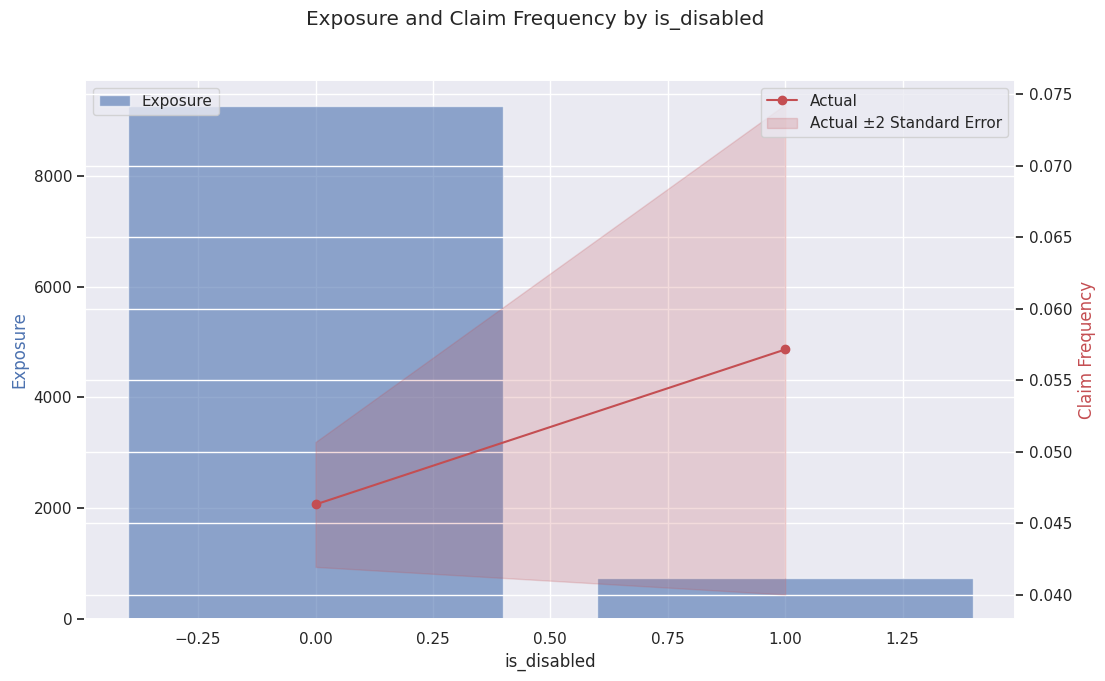

[0.0]


In [67]:
plotave(df,'is_disabled',recommendBanding=True)

In [68]:
plotave(df,'is_disabled',ValueCol='M',recommendBanding=True)

[0.0, 1.0]


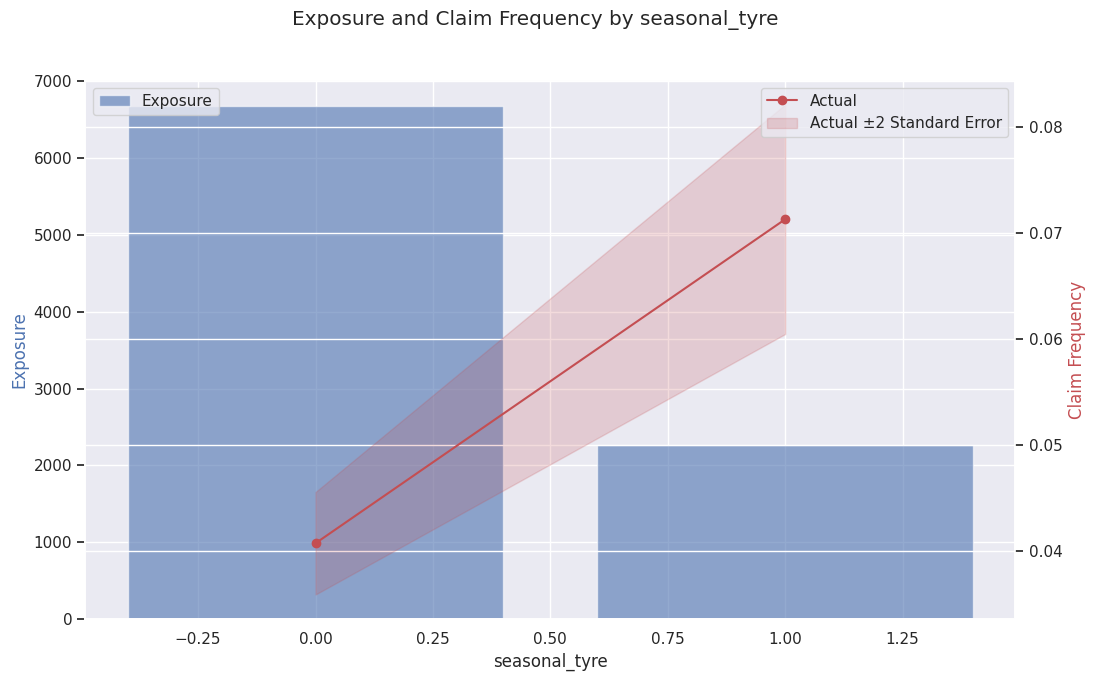

[0.0, 1.0]


In [69]:
plotave(df,'seasonal_tyre',recommendBanding=True)

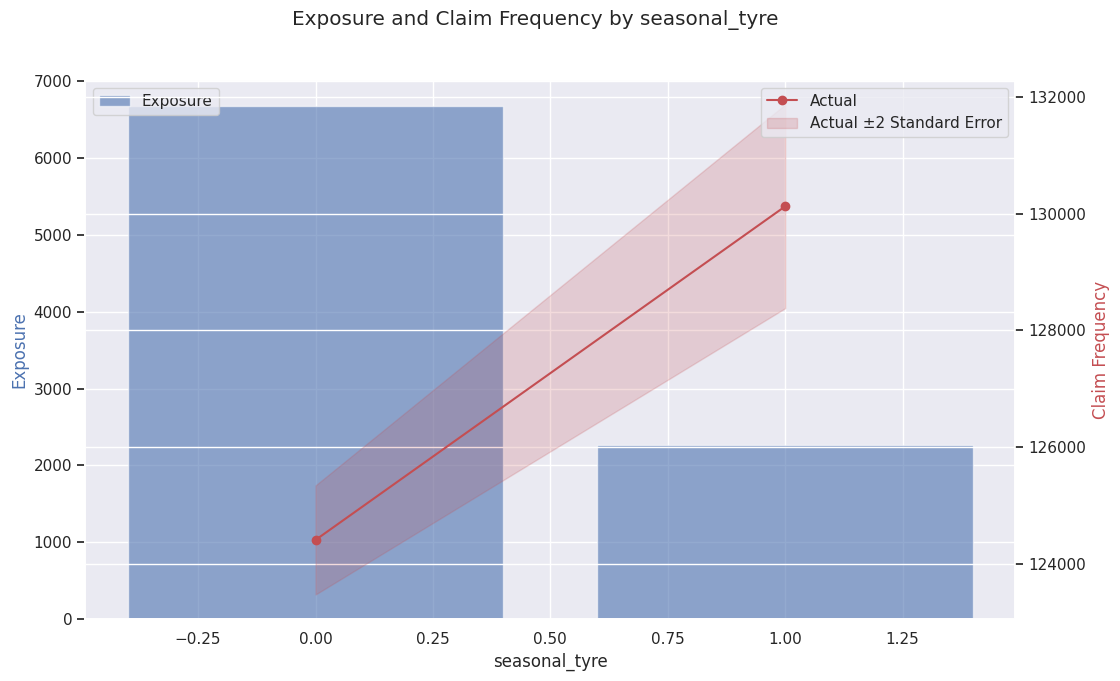

[0.0, 1.0]


In [70]:
plotave(df,'seasonal_tyre',ValueCol='M',recommendBanding=True)

In [96]:
# Load the territory data with European formatting
t = pd.read_csv('/kaggle/input/territory3/territory.csv', 
                sep=';',  # Semicolon as separator
                decimal=',')  # Comma as decimal point

# Perform a left join on postcode (df) and zip (t)
df = df.merge(t[['zip', '_carperroadkm','_adultperkm2']], 
              left_on='postcode', right_on='zip', 
              how='left')

# Fill missing values in adultperkm2 with 1000
df['_carperroadkm'].fillna(0.5)

# Drop redundant 'zip' column if not needed
df.drop(columns=['zip'], inplace=True)


<ipython-input-86-13d234fad6dc>:119: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result[GroupByCol] = result.groupby('bins')[GroupByCol].transform('min')


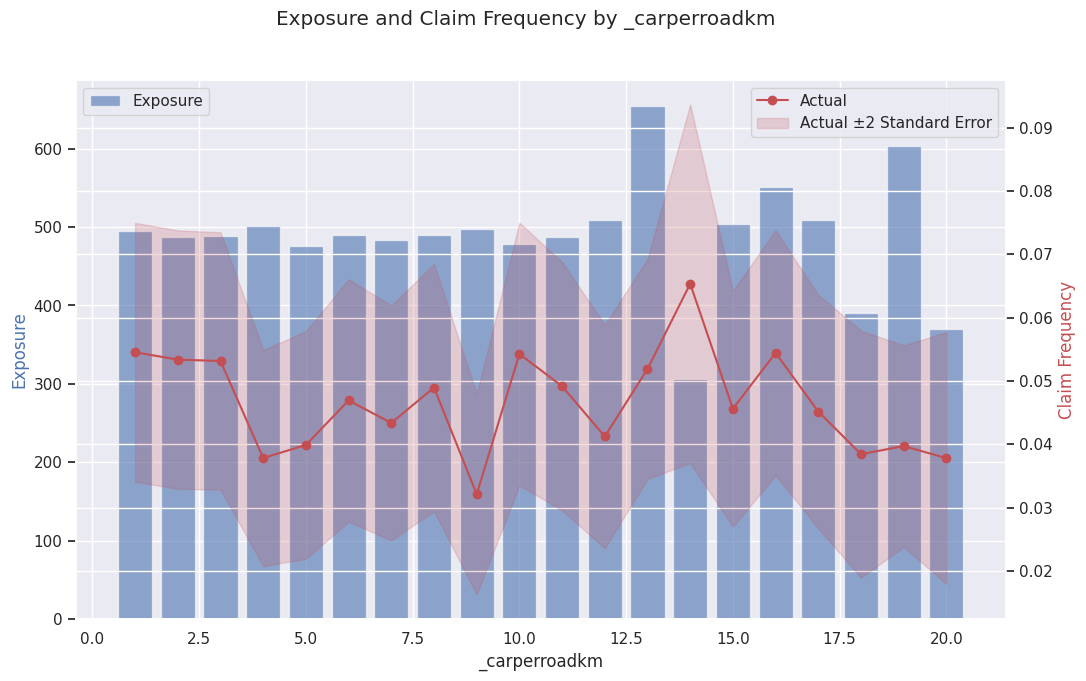

[0.002, 0.741, 0.79]
Original Value  0.002  0.741   0.79
Rank            1.000  9.000  10.00


In [97]:
plotave(df,'_carperroadkm',resetXaxis=True,recommendBanding=True, nbins=20)

<ipython-input-86-13d234fad6dc>:119: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result[GroupByCol] = result.groupby('bins')[GroupByCol].transform('min')


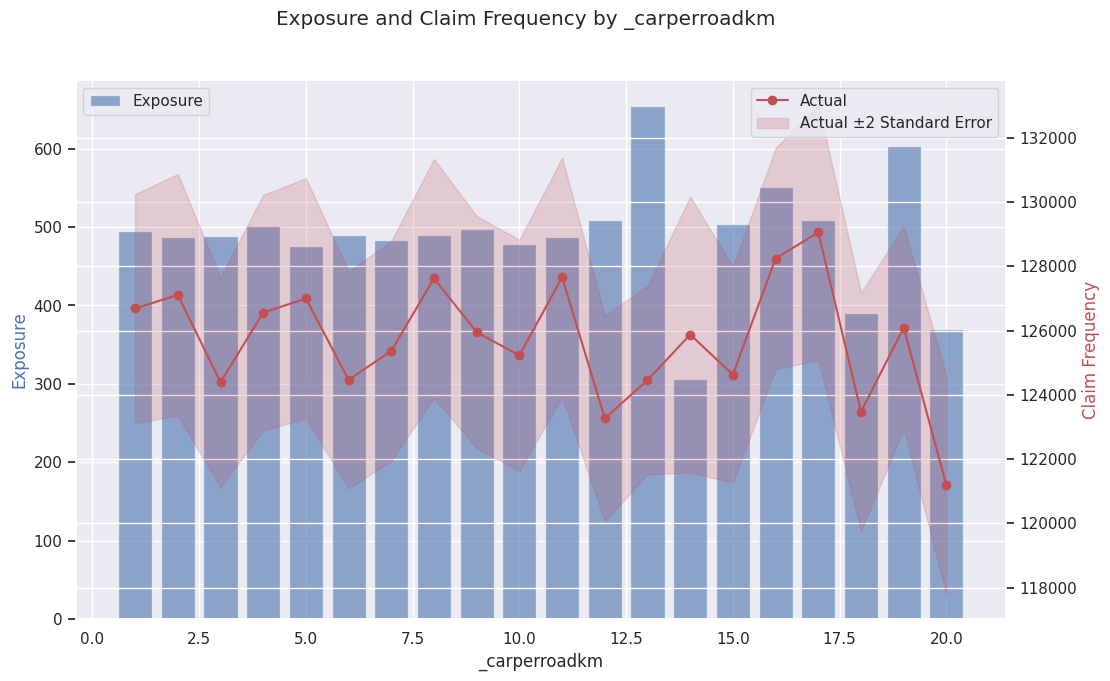

[0.002, 0.981]
Original Value  0.002   0.981
Rank            1.000  20.000


In [98]:
plotave(df,'_carperroadkm',ValueCol='M',resetXaxis=True,recommendBanding=True, nbins=20)

<ipython-input-86-13d234fad6dc>:119: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result[GroupByCol] = result.groupby('bins')[GroupByCol].transform('min')


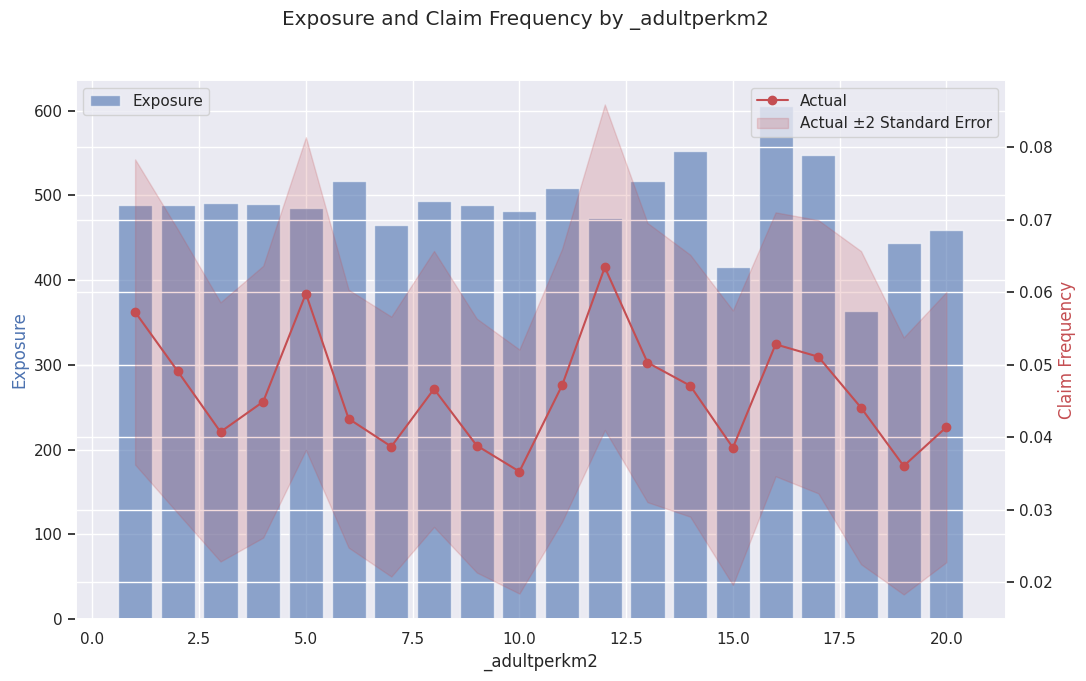

[0.001, 0.829, 0.872, 0.917]
Original Value  0.001   0.829   0.872   0.917
Rank            1.000  10.000  12.000  15.000


In [99]:
plotave(df,'_adultperkm2',resetXaxis=True,recommendBanding=True, nbins=20)

<ipython-input-86-13d234fad6dc>:119: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result[GroupByCol] = result.groupby('bins')[GroupByCol].transform('min')


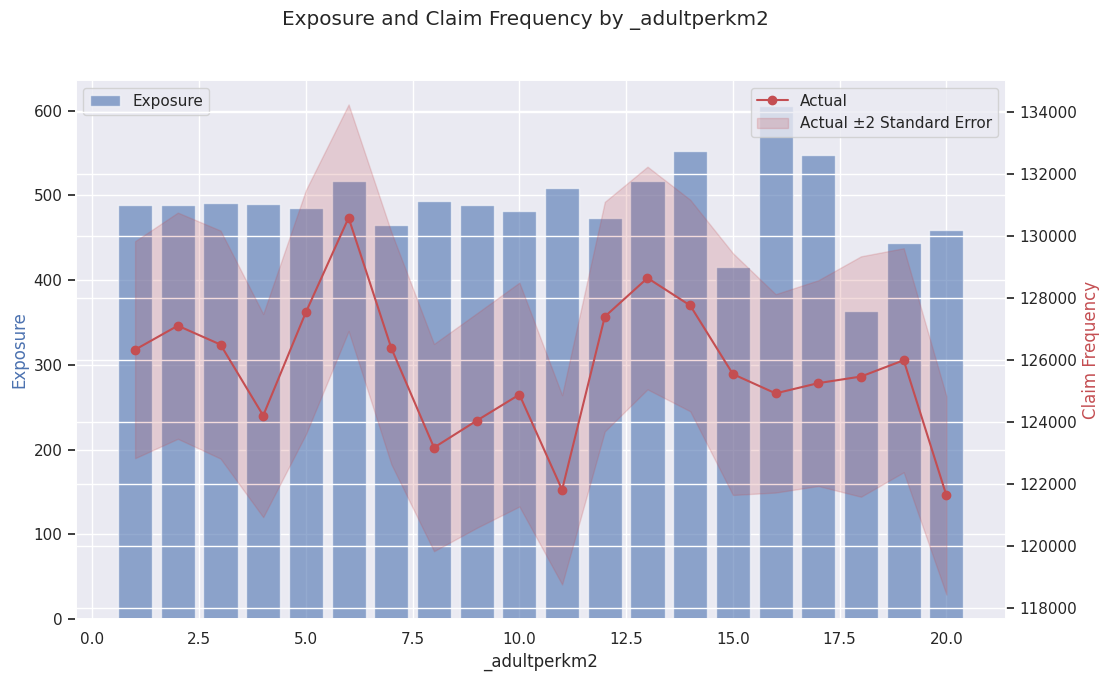

[0.001, 0.653, 0.711, 0.856, 0.872, 0.979]
Original Value  0.001  0.653  0.711   0.856   0.872   0.979
Rank            1.000  6.000  7.000  11.000  12.000  20.000


In [100]:
plotave(df,'_adultperkm2',ValueCol='M',resetXaxis=True,recommendBanding=True, nbins=20)

In [3]:
#Reloading the database just to be safe.
df = pd.read_excel('/kaggle/input/v-type-data/kgfb_sim_fr_feb01.xlsx')

bandings = {
    'VehPower': [4, 5, 7, 8, 9, 10, 11],
    'VehAge': [0, 1, 2, 4, 6, 8, 13, 15, 18],
    # DrivAge skipped
    'BonusMalus': [50, 52, 53, 55, 56, 57, 58, 59, 60, 62, 63, 64, 67, 68, 71, 72, 76, 90, 95, 100, 101],
    'licence_age': [0.0, 3.0, 5.0, 7.0, 9.0, 10.0, 11.0, 14.0, 19.0, 22.0, 25.0, 35.0, 37.0, 42.0, 46.0, 56.0, 57.0],
    'n_drivers': [1.0, 2.0, 3.0],
    'young_driver':[18.0, 19.0, 20.0, 23.0, 27.0, 29.0, 31.0, 32.0, 34.0, 37.0, 38.0, 41.0, 53.0, 68.0, 69.0, 79.0, 81.0, 83.0],
    'DrivAge':[18.0, 21.0, 23.0, 25.0, 27.0, 28.0, 29.0, 31.0, 32.0, 34.0, 37.0, 39.0, 43.0, 46.0, 51.0, 52.0, 59.0, 60.0, 62.0, 68.0, 69.0]
    ,'old_driver':[18.0, 23.0, 25.0, 27.0, 28.0, 29.0, 31.0, 32.0, 34.0, 37.0, 38.0, 41.0, 53.0, 55.0, 58.0, 59.0, 60.0, 63.0, 64.0, 67.0, 79.0]
    ,'domestic':[0.0, 1000.0, 3000.0, 4000.0, 5000.0, 6000.0, 7000.0, 8000.0, 9000.0, 10000.0, 11000.0, 12000.0, 13000.0, 18000.0]
    ,'foreign':[0.0, 1500.0, 2000.0, 2500.0, 4000.0, 5000.0, 6000.0, 6500.0, 7000.0, 8500.0, 9500.0]    
    ,'is_retired':[0.0, 1.0]#This isn't an actual altering, but to keep it uniform
    ,'is_disabled':[0.0, 1.0]#This isn't an actual altering, but to keep it uniform
    ,'seasonal_tyre':[0.0, 1.0]#This isn't an actual altering, but to keep it uniform
}
df = add_banding_columns(df, bandings)
df = df.drop(columns=['odometer','daily_commute','operator','non_payment','payment_method','casco',])#postcode can't be used

NameError: name 'pd' is not defined

In [2]:
import pandas as pd

# Load datasets
hungary_drive = pd.read_csv("/kaggle/input/hungarytownshoursdrive/HungaryTownsHoursDrive.csv", sep=";")
# Function to clean town names
def clean_town_name(town):
    #town = town.strip()  # Remove leading/trailing spaces
    town = town.replace(". kerület", "")  # Remove district markers
    town = town.replace(" ", "")  # Remove spaces
    return town

# Apply cleaning function
hungary_drive["Var1"] = hungary_drive["Var1"].apply(clean_town_name)
hungary_drive["Var2"] = hungary_drive["Var2"].apply(clean_town_name)

zip_town = pd.read_csv("/kaggle/input/ziptown/ZipTown.csv", sep=";")

# Extract unique town names from both datasets
towns_in_drive = set(hungary_drive["Var1"]).union(set(hungary_drive["Var2"]))
towns_in_zip = set(zip_town["town"])

# Find missing towns
missing_in_zip = towns_in_drive - towns_in_zip  # Towns in HungaryTownsHoursDrive but not in ZipTown
missing_in_drive = towns_in_zip - towns_in_drive  # Towns in ZipTown but not in HungaryTownsHoursDrive

# Display results
missing_towns_df = pd.DataFrame({
    "Missing in ZipTown": list(missing_in_zip) + [None] * (max(len(missing_in_zip), len(missing_in_drive)) - len(missing_in_zip)),
    "Missing in HungaryTownsHoursDrive": list(missing_in_drive) + [None] * (max(len(missing_in_zip), len(missing_in_drive)) - len(missing_in_drive))
})

missing_towns_df

Empty DataFrame
Columns: [Missing in ZipTown, Missing in HungaryTownsHoursDrive]
Index: []

In [2]:
# Merge hungary_drive with zip_town to get zip codes for Var1 and Var2
zipduration = hungary_drive.merge(zip_town, left_on="Var1", right_on="town", how="inner") \
                           .rename(columns={"zip": "zip1"}) \
                           .merge(zip_town, left_on="Var2", right_on="town", how="inner") \
                           .rename(columns={"zip": "zip2"}) \
                           [["zip1", "zip2", "Duration"]]

# Compute the minimum duration grouped by zip codes
zipduration = zipduration.groupby(["zip1", "zip2"], as_index=False)["Duration"].min()
zipduration.rename(columns={"Duration": "hours"}, inplace=True)

In [3]:
zipduration.to_csv("zipduration1.csv", index=False, sep=";")

In [ ]:
#unfortunatelly, this part didn't run in Kaggle
zipduration = zipduration.merge(zipduration, left_on="zip1", right_on="zip2", suffixes=("_a", "_b"))
zipduration["hours"] = zipduration[["hours_a", "hours_b"]].min(axis=1)
zipduration = zipduration[["zip1_a", "zip2_a", "hours"]].rename(columns={"zip1_a": "zip1", "zip2_a": "zip2"})

In [10]:
zh = pd.read_csv('/kaggle/input/ziphours/ziphours.csv',decimal=',',sep=";")

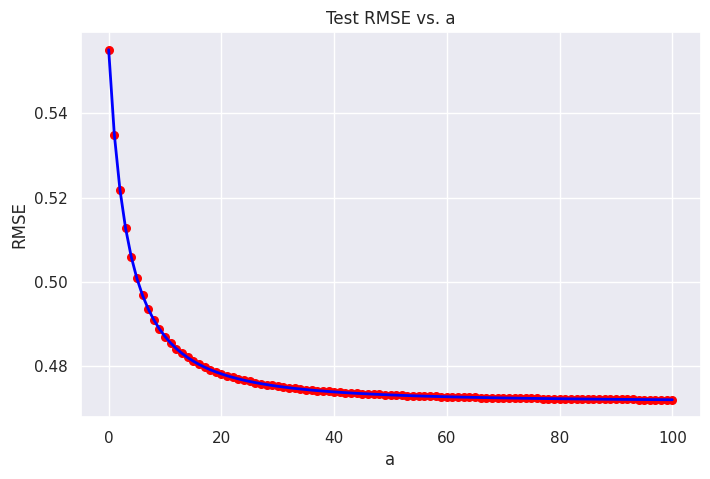

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Load data (assuming df and zh are already loaded as pandas DataFrames)
df = df[df["postcode"].notna()].copy()
zh = zh.copy()

# Train-test split
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

# Merge train_data with ziphours (zh)
merged_train = train_data.merge(zh, left_on="postcode", right_on="zip1", how="inner")

# Compute smoothed means
train_results = merged_train.groupby("zip2").agg(
    clmnummean=("V", lambda x: np.mean(np.exp(-merged_train.loc[x.index, "hours"]) * x)),
    exposuremean=("V", lambda x: np.mean(np.exp(-merged_train.loc[x.index, "hours"]) * 1))
).reset_index()

# Merge back with train_data
train_results = train_results.merge(train_data, left_on="zip2", right_on="postcode", how="inner")

# Define a sequence of 'a' values from 0 to 0.25
a_values = np.linspace(0, 100, 101)

# Create a results list
rmse_test_list = []

# Loop over each value of 'a' and compute RMSE
for a in a_values:
    # Compute crdaily (claim rate per daily exposure)
    temp_train_results = train_results.copy()
    temp_train_results["crdaily"] = (temp_train_results["V"] + a * temp_train_results["clmnummean"]) / \
                                    (1 + a * temp_train_results["exposuremean"])
    
    # Merge test data with train_results to match predictions
    test_results = test_data.merge(temp_train_results[["zip2", "crdaily"]], left_on="postcode", right_on="zip2", how="inner")

    # Compute RMSE for current 'a'
    rmse_value = np.sqrt(mean_squared_error(test_results["V"], test_results["crdaily"], squared=False))
    
    # Store result
    rmse_test_list.append({"a": a, "RMSE": rmse_value})

# Convert results to DataFrame
rmse_test_results = pd.DataFrame(rmse_test_list)

# Plot RMSE vs. a
plt.figure(figsize=(8, 5))
plt.plot(rmse_test_results["a"], rmse_test_results["RMSE"], color="blue", linewidth=2)
plt.scatter(rmse_test_results["a"], rmse_test_results["RMSE"], color="red", s=30)
plt.xlabel("a")
plt.ylabel("RMSE")
plt.title("Test RMSE vs. a")
plt.grid(True)
plt.show()


In [18]:
print(test_results.isna().sum())  # Shows count of NaNs per column


V                    0
M                    0
VehPower             0
VehAge               0
DrivAge              0
BonusMalus           0
postcode             0
licence_age        735
n_drivers            0
young_driver         0
old_driver           0
domestic             0
foreign              0
is_financed          0
is_rh             1727
fuel                 0
odometer             0
daily_commute        0
exam                 0
operator             0
non_payment          0
payment_method       0
casco                0
is_retired           0
is_disabled          0
seasonal_tyre     1424
zip2               203
crdaily            203
dtype: int64


In [116]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Selecting predictors that start with '_'
predictors = [col for col in df.columns if col.startswith('_')]

# Defining features (X) and target (y)
X = df[predictors]
y = df['V']

# Standardizing features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Training a Lasso Logistic Regression model
lasso_model = LogisticRegression(penalty='l1', solver='liblinear', C=1.0)
lasso_model.fit(X_train, y_train)

# Predict probabilities
proba_predictions = lasso_model.predict_proba(df)[:, 1]

# Convert X_test back to DataFrame before adding probabilities
X_test_df = pd.DataFrame(X_test, columns=predictors)

# Add predicted probabilities as a new column
df['Vp'] = proba_predictions 
#X_test_df['V'] = y_test

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


ValueError: could not convert string to float: 'plug in hybrid'

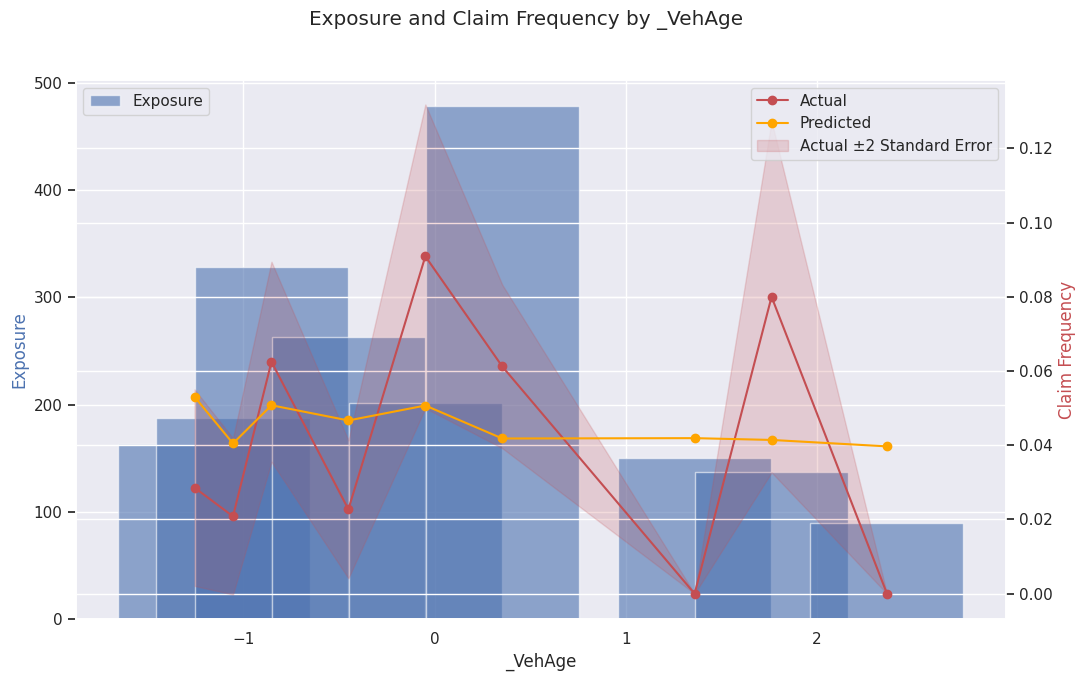

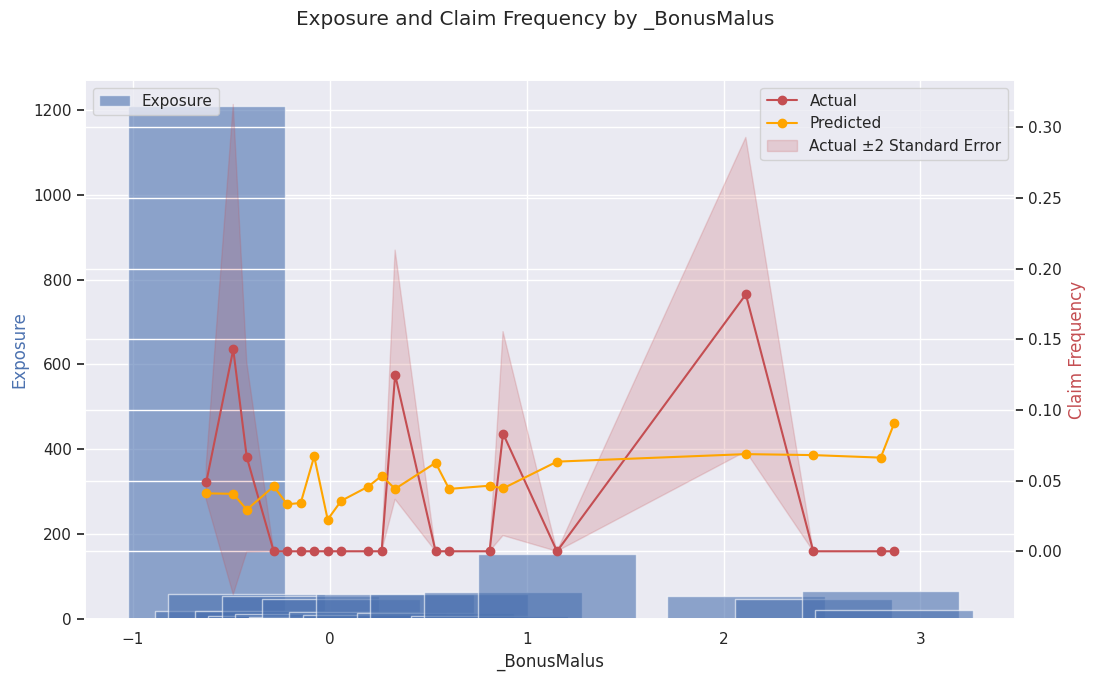

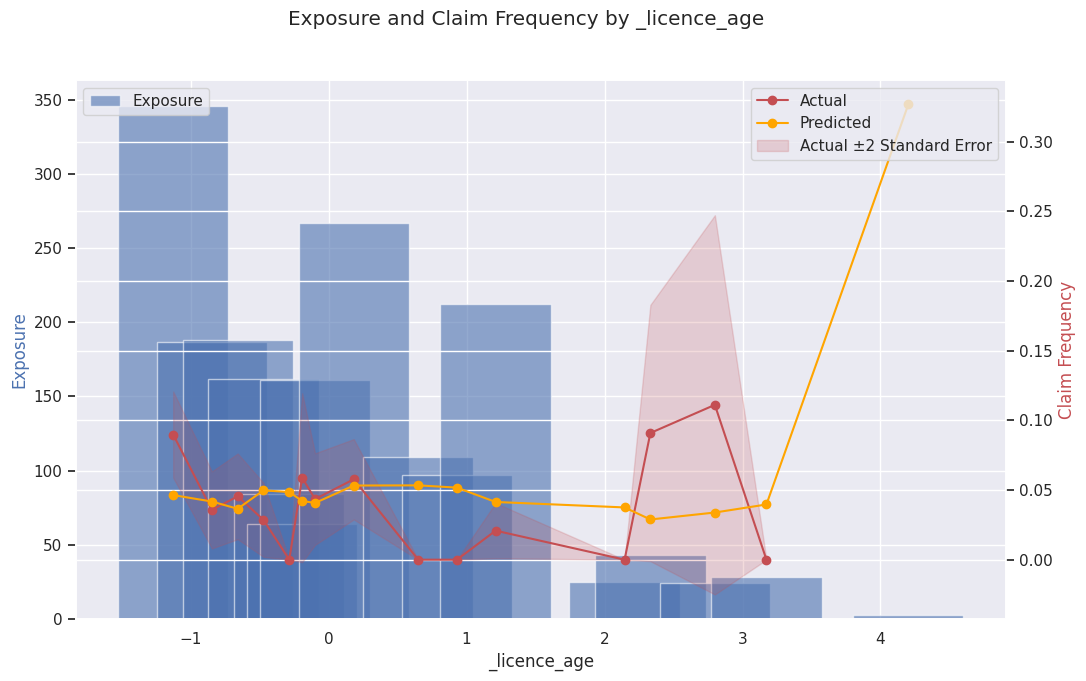

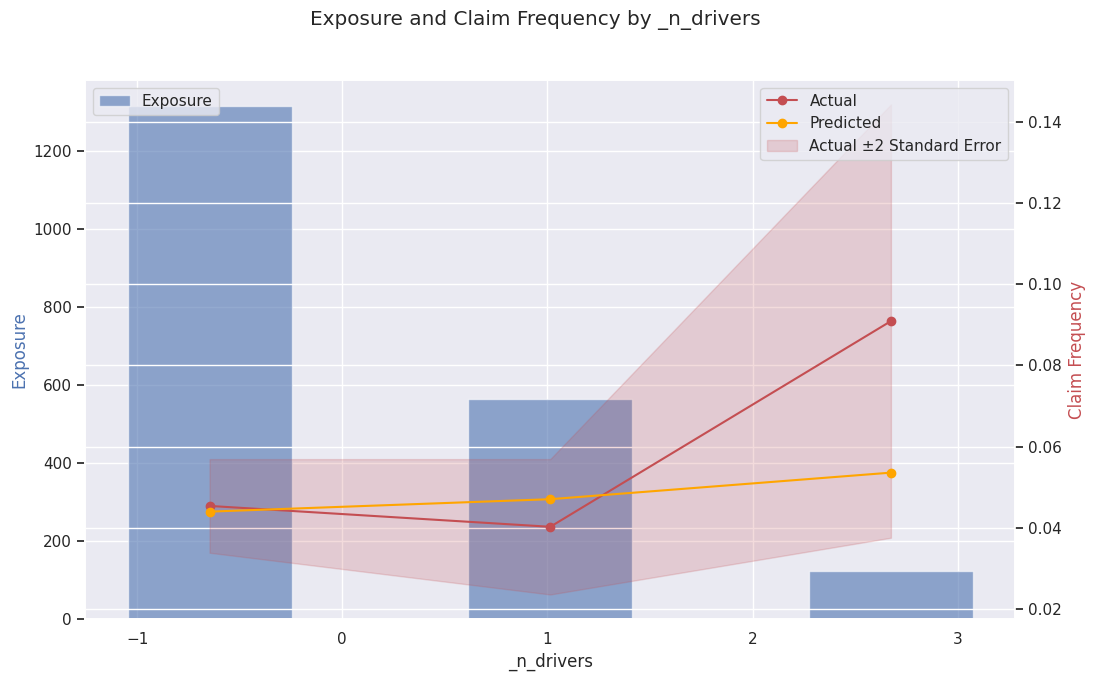

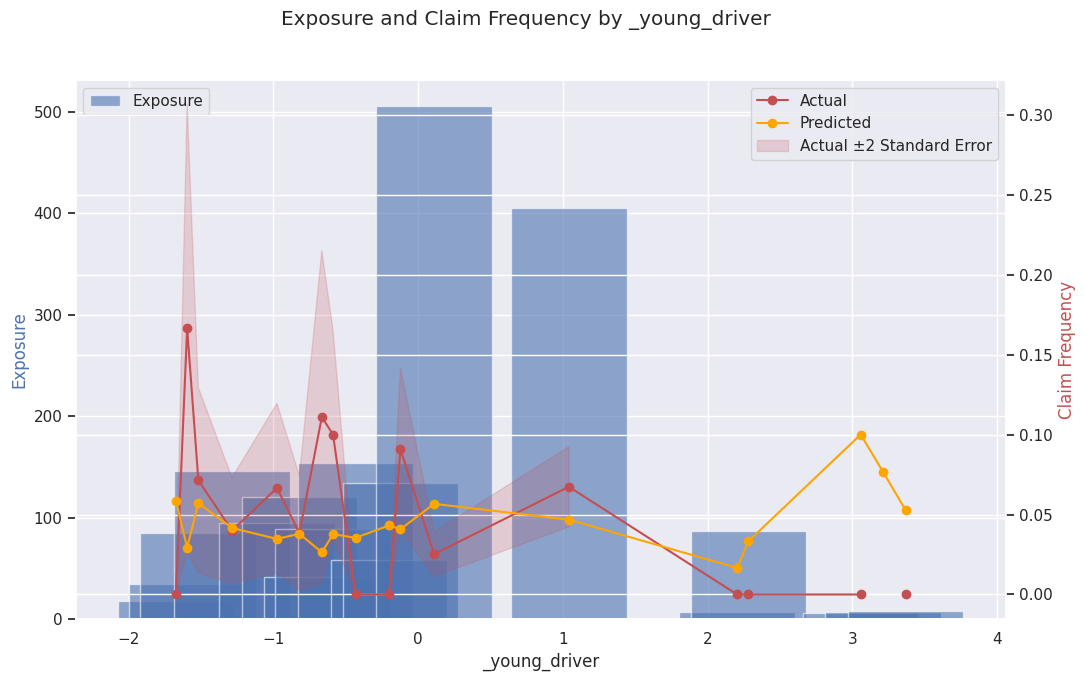

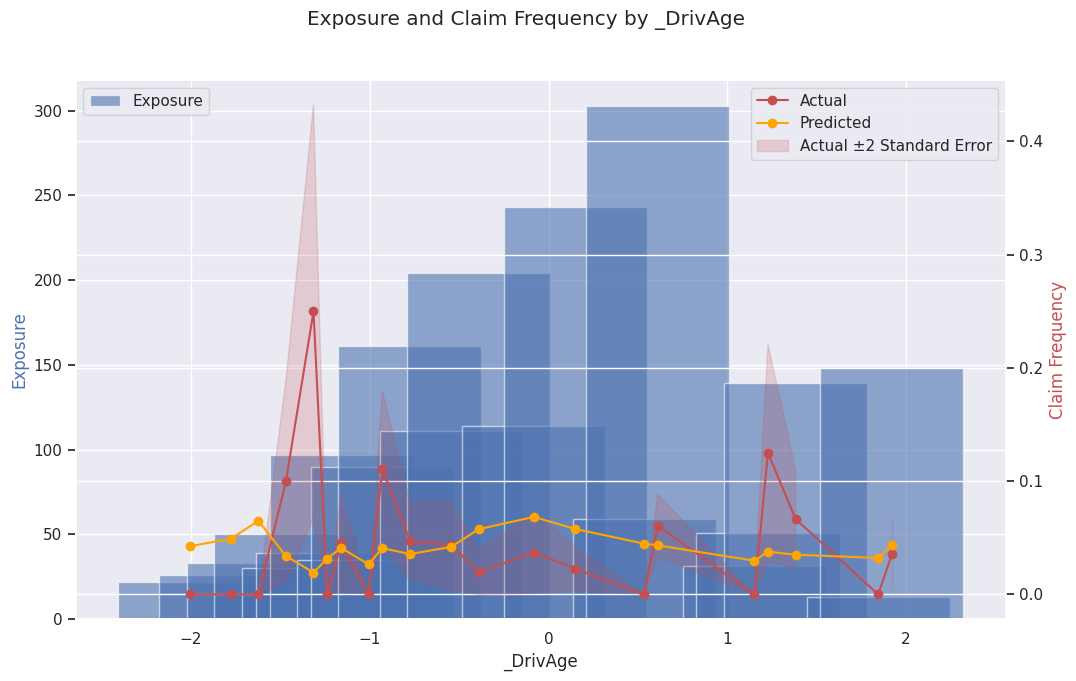

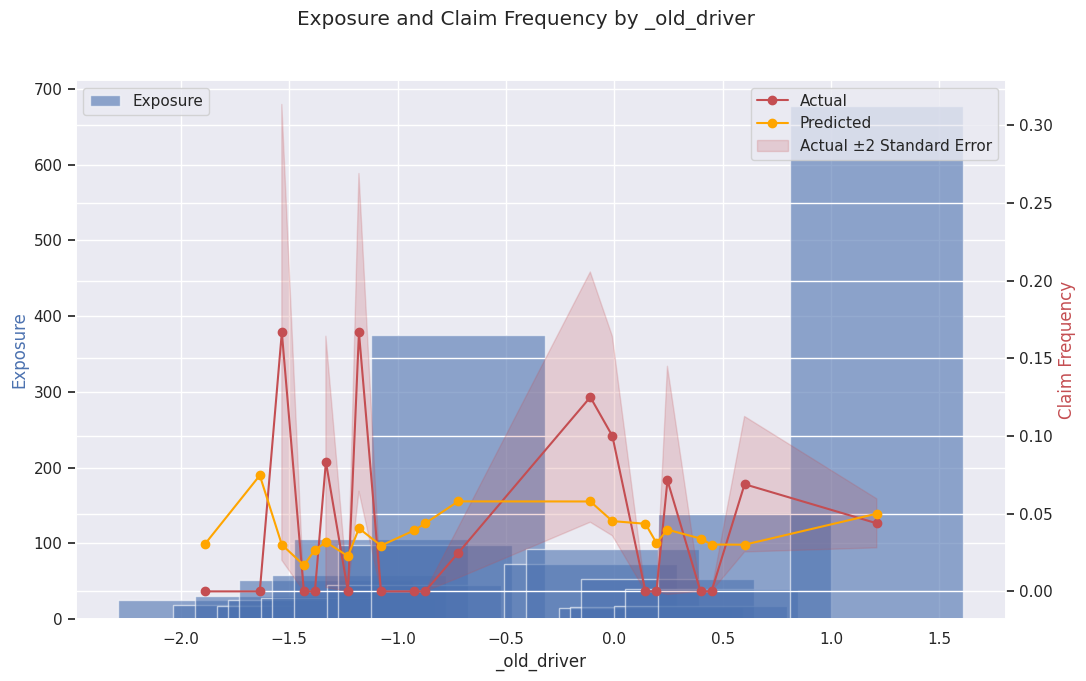

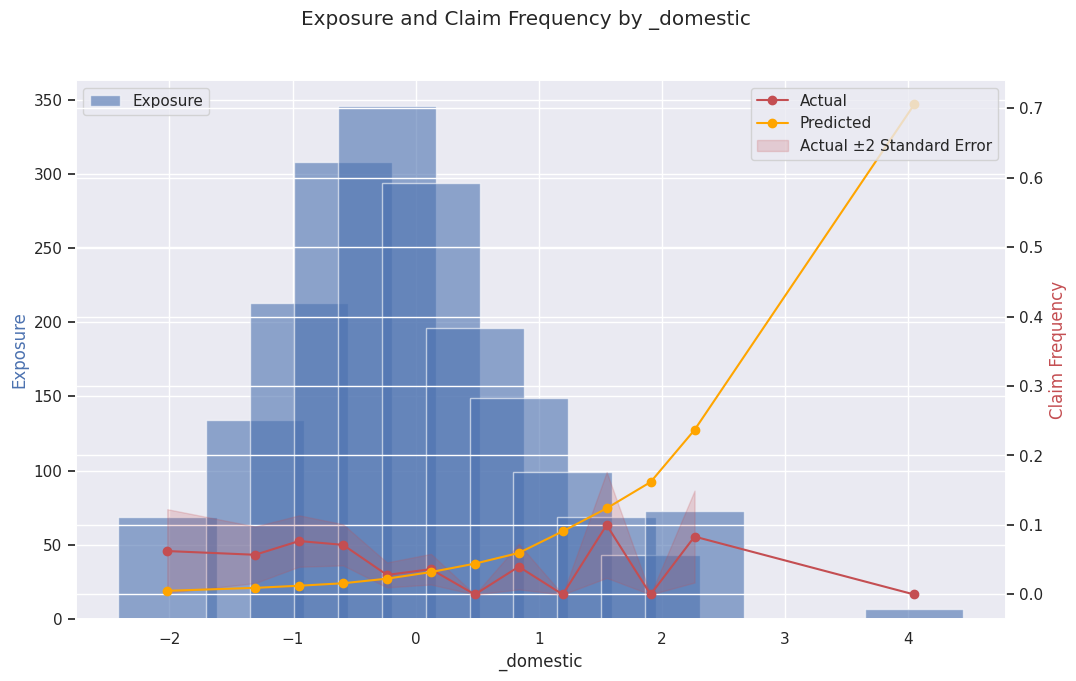

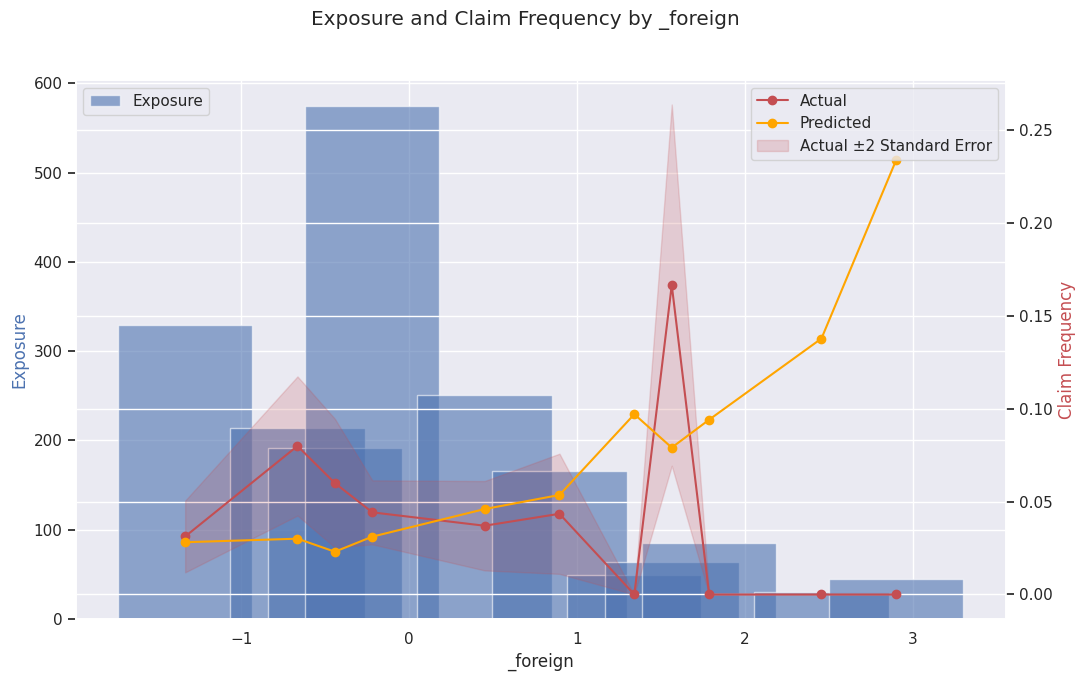

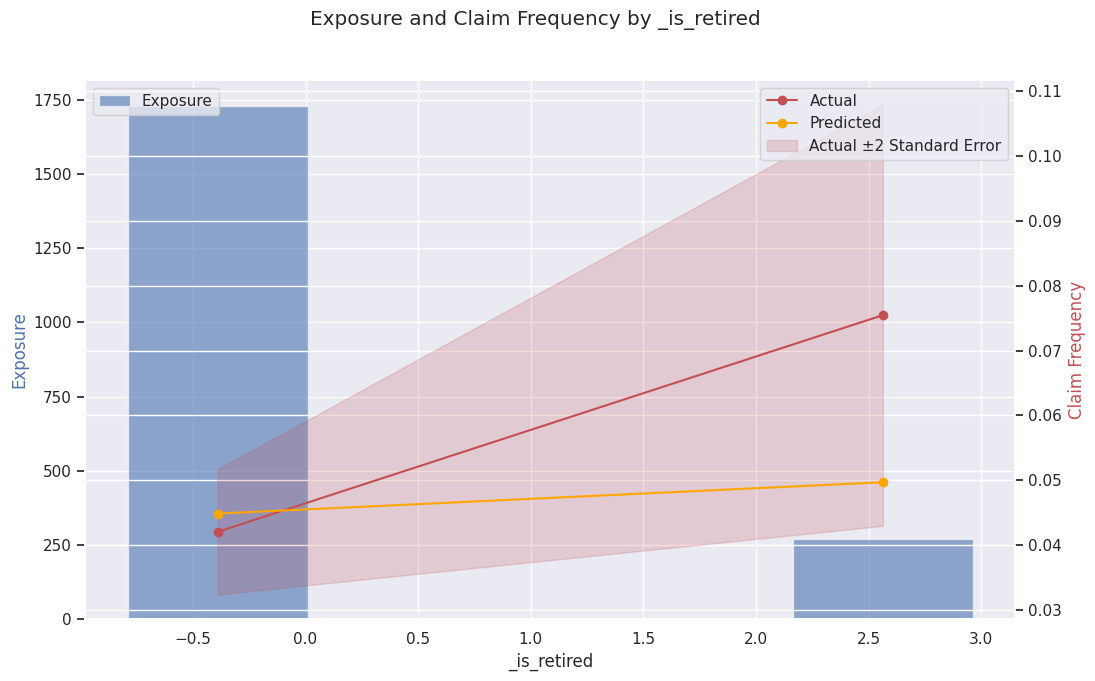

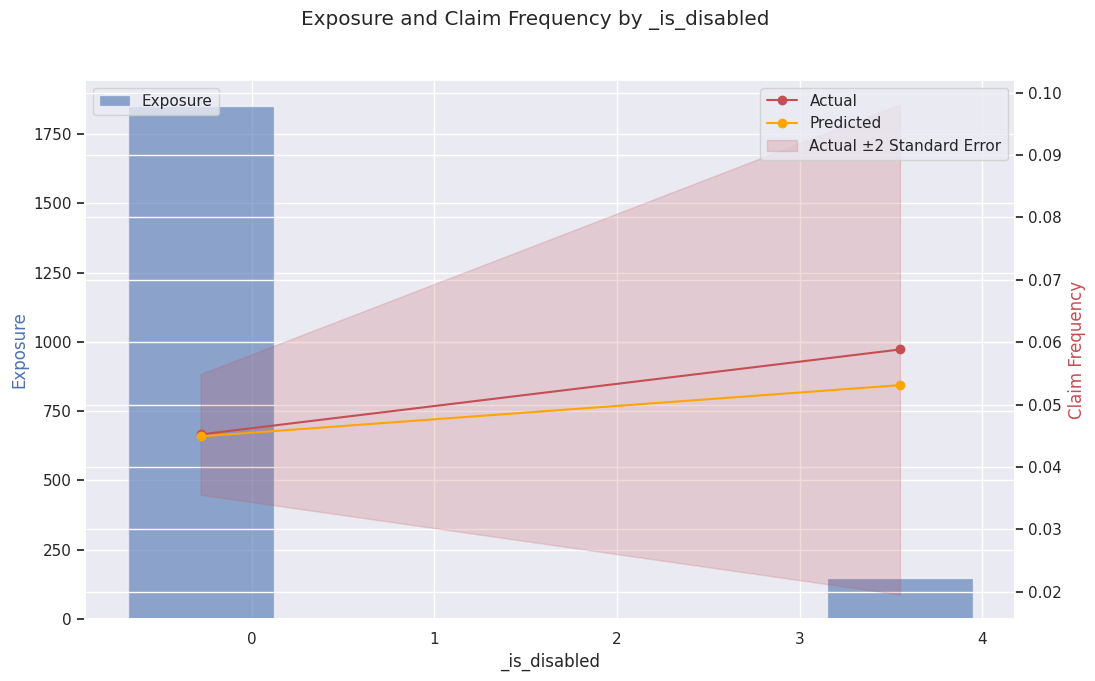

In [115]:
plotave(X_test_df,predictors,PredictedCol='Vp')

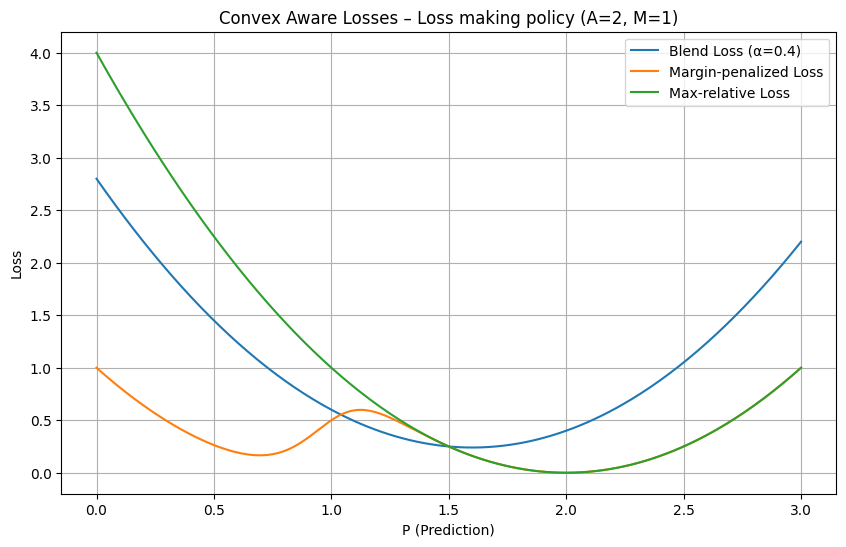

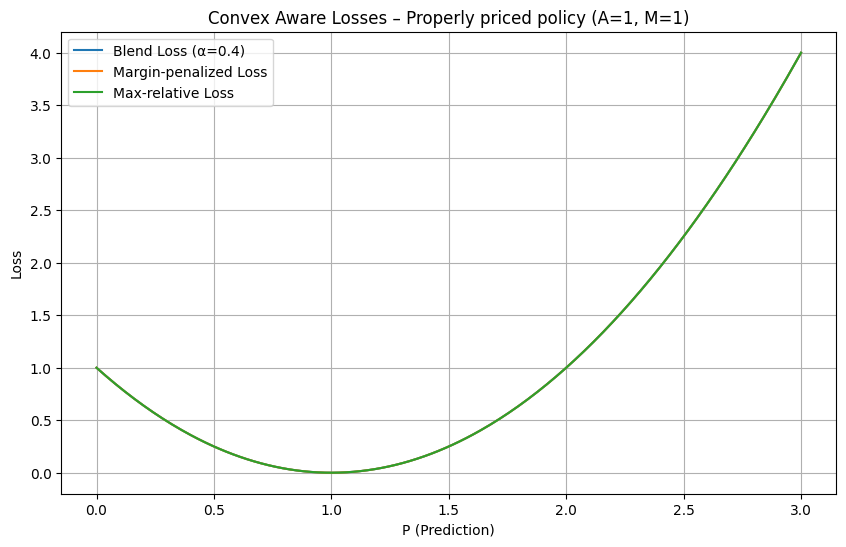

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Loss functions using A and M
def blend_loss(P, A, M, alpha=0.5):
    return (1 - alpha) * (P - A) ** 2 + alpha * (P - M) ** 2

def max_relative_loss(P, A, M):
    return (P - np.maximum(A, M)) ** 2

def smooth_margin_penalized_loss(P, A, M, sharpness=10):
    w = 1 / (1 + np.exp(-sharpness * (M - P)))  # sigmoid centered at M
    return w * (M - P) ** 2 + (1 - w) * (P - A) ** 2

# P values
P = np.linspace(0, 3, 300)

# Different policy scenarios
scenarios = [
    {"A": 1, "M": 2, "title": "Profit making policy"},
    {"A": 2, "M": 1, "title": "Loss making policy"},
    {"A": 1, "M": 1, "title": "Properly priced policy"},
]

# Plot
for s in scenarios:
    A = s["A"]
    M = s["M"]
    title = s["title"]

    plt.figure(figsize=(10, 6))
    plt.plot(P, blend_loss(P, A, M, alpha=0.4), label="Blend Loss (α=0.4)")
    plt.plot(P, smooth_margin_penalized_loss(P, A, M), label="Margin-penalized Loss")
    plt.plot(P, max_relative_loss(P, A, M), label="Max-relative Loss")
    plt.title(f"Convex Aware Losses – {title} (A={A}, M={M})")
    plt.xlabel("P (Prediction)")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()


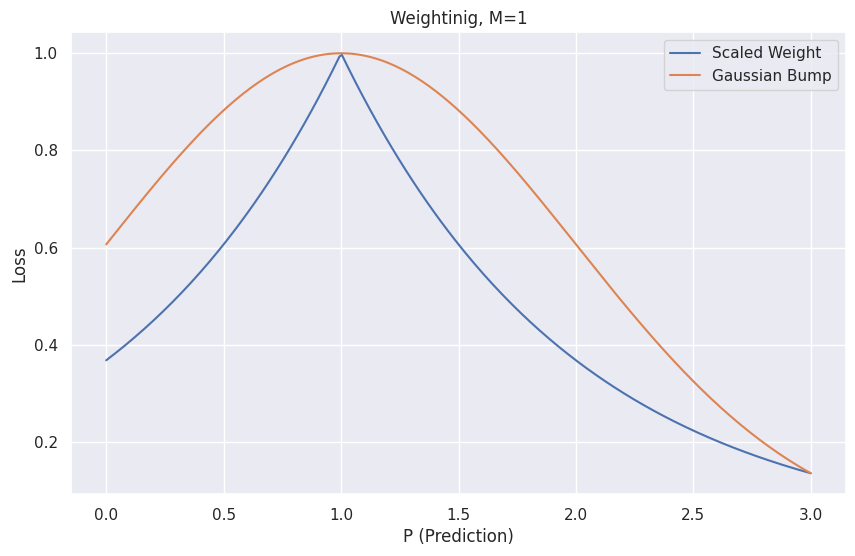

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def scaledw(T_hat, M, scale=1.0):
    return np.exp(-scale * np.abs(T_hat - M))

def bump(T_hat, M, sigma=1.0):
    return np.exp(-0.5 * ((T_hat - M)/sigma)**2)

# P values
T_hat = np.linspace(0, 3, 300)

# Different policy scenarios
scenarios = [
    {"A": 1, "M": 2, "title": "Profit making policy"},
    {"A": 2, "M": 1, "title": "Loss making policy"},
    #{"A": 1, "M": 1, "title": "Properly priced policy"},
]

# Plot
for s in scenarios:
    A = s["A"]
    M = s["M"]
    title = s["title"]

    plt.figure(figsize=(10, 6))
    plt.plot(P, scaledw(T_hat, M), label="Scaled Weight")
    plt.plot(P, bump(T_hat, M), label="Gaussian Bump")
    #plt.plot(P, smooth_margin_penalized_loss(P, A, M), label="Margin-penalized Loss")
    plt.title(f"Weightinig, M={M}")
    plt.xlabel("P (Prediction)")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()


In [10]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

# ----- Setup -----
def weight(t_hat, M, sigma=1.0):
    return np.exp(-0.5 * ((t_hat - M)/sigma)**2)

def profit(p, t_hat, M):
    return np.where(p >= M, 0.0, t_hat - p)

def evaluate(p, t_hat, M, A):
    """Composite score: combines profit + how well t_hat predicts A"""
    prof = profit(p, t_hat, M)
    mse = mean_squared_error(t_hat, A)
    total_profit = np.sum(prof)
    return {
        'profit': total_profit,
        'mse_t_hat_vs_A': mse,
        'score': total_profit - mse  # can be tuned
    }

# ----- Data (toy example) -----
np.random.seed(42)
n = 500
X = np.random.randn(n, 3)
A = np.random.exponential(scale=5, size=n)
A[np.random.rand(n) < 0.5] = 0  # introduce many 0s (noisy A)
M = np.full(n, 4.0)  # or make M = f(X) if dynamic

# ----- Initialize -----
T_hat = pd.Series(pd.Series(A).rolling(20, min_periods=1).mean())  # crude denoising

# ----- Iterative loop -----
n_iter = 10
model = Ridge()

for i in range(n_iter):
    # 1. Fit P using current T_hat weights
    W = weight(T_hat, M, sigma=2.0)
    model.fit(X, T_hat, sample_weight=W)
    P = model.predict(X)

    # 2. Evaluate
    score_dict = evaluate(P, T_hat, M, A)
    print(f"[Iter {i+1}] Profit: {score_dict['profit']:.2f}, MSE to A: {score_dict['mse_t_hat_vs_A']:.2f}, Score: {score_dict['score']:.2f}")

    # 3. Update T_hat ← new P (soft update is also possible)
    T_hat = 0.5 * T_hat + 0.5 * P  # or T_hat = P

# Final model: f(X) → P ≈ expected T near margin


[Iter 1] Profit: -105.43, MSE to A: 16.24, Score: -121.67
[Iter 2] Profit: -27.07, MSE to A: 16.50, Score: -43.56
[Iter 3] Profit: -6.82, MSE to A: 16.73, Score: -23.55
[Iter 4] Profit: -1.71, MSE to A: 16.87, Score: -18.58
[Iter 5] Profit: -0.43, MSE to A: 16.95, Score: -17.38
[Iter 6] Profit: -0.11, MSE to A: 16.99, Score: -17.10
[Iter 7] Profit: -0.03, MSE to A: 17.01, Score: -17.04
[Iter 8] Profit: -0.01, MSE to A: 17.02, Score: -17.03
[Iter 9] Profit: -0.00, MSE to A: 17.03, Score: -17.03
[Iter 10] Profit: -0.00, MSE to A: 17.03, Score: -17.03


[Iter 1] MSE: 4.80, Bad Policy: 100.0%, Missed Opp: 0.0%, Profit: 1.43
[Iter 2] MSE: 4.83, Bad Policy: 100.0%, Missed Opp: 0.0%, Profit: 4.21
[Iter 3] MSE: 4.89, Bad Policy: 100.0%, Missed Opp: 0.0%, Profit: 3.04
[Iter 4] MSE: 4.94, Bad Policy: 100.0%, Missed Opp: 0.0%, Profit: 1.76
[Iter 5] MSE: 4.97, Bad Policy: 100.0%, Missed Opp: 0.0%, Profit: 0.94
[Iter 6] MSE: 4.98, Bad Policy: 100.0%, Missed Opp: 0.0%, Profit: 0.49
[Iter 7] MSE: 4.99, Bad Policy: 100.0%, Missed Opp: 0.0%, Profit: 0.25
[Iter 8] MSE: 5.00, Bad Policy: 100.0%, Missed Opp: 0.0%, Profit: 0.12
[Iter 9] MSE: 5.00, Bad Policy: 100.0%, Missed Opp: 0.0%, Profit: 0.06
[Iter 10] MSE: 5.00, Bad Policy: 100.0%, Missed Opp: 0.0%, Profit: 0.03


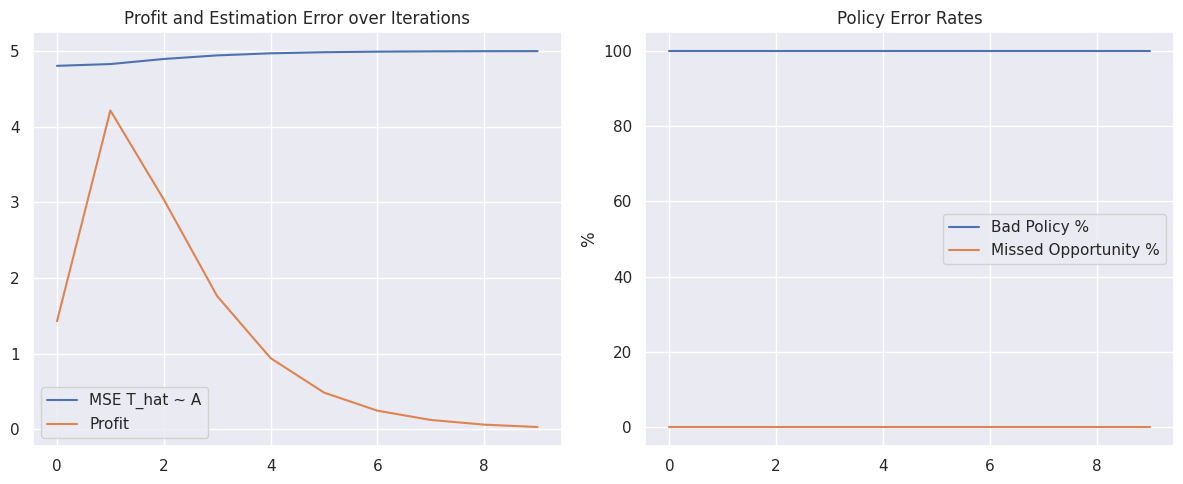

In [13]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# ---- Improved Data Simulation ----
np.random.seed(42)
n = 1000
X = np.random.randn(n, 3)
T = 3 + X[:, 0] + 0.5 * X[:, 1]  # hidden true expected value
noise = np.random.normal(0, 2, size=n)
A = np.maximum(0, T + noise)  # observed samples
M = np.full(n, 4.0)  # fixed threshold

# ---- Train-test split ----
X_train, X_test, A_train, A_test, T_train, T_test, M_train, M_test = train_test_split(
    X, A, T, M, test_size=0.3, random_state=42
)

# ---- Init T_hat ----
T_hat_train = pd.Series(A_train).rolling(20, min_periods=1).mean().to_numpy()
T_hat_test = pd.Series(A_test).rolling(20, min_periods=1).mean().to_numpy()

# ---- Utility functions ----
def weight(t_hat, M, sigma=1.0):
    return np.exp(-0.5 * ((t_hat - M)/sigma)**2)

def profit(p, t_hat, M):
    return np.where(p >= M, 0.0, t_hat - p)

def evaluate_full(p, t_hat, M, A):
    mse = mean_squared_error(t_hat, A)

    # BAD POLICY: predicted P < M, but A > M
    mask_profitable = A > M
    mask_loss_making = (p < M) & mask_profitable
    total_possible_profit = np.sum(A[mask_profitable] - M[mask_profitable])
    lost_profit = np.sum(A[mask_loss_making] - M[mask_loss_making])
    bad_policy_rate = (lost_profit / total_possible_profit) if total_possible_profit > 1e-8 else 0.0

    # MISSED OPPORTUNITY: predicted P ≥ M, but A > M (we didn't act but should have)
    mask_missed = (p >= M) & (A > M)
    missed_opportunity = np.sum(A[mask_missed] - M[mask_missed])
    missed_opportunity_rate = (missed_opportunity / total_possible_profit) if total_possible_profit > 1e-8 else 0.0

    total_profit = np.sum(profit(p, t_hat, M))

    return {
        'mse_T_hat_vs_A': mse,
        'bad_policy_rate': bad_policy_rate,
        'missed_opportunity_rate': missed_opportunity_rate,
        'total_profit': total_profit
    }

# ---- Train loop ----
n_iter = 10
model = Ridge()

history = []

for i in range(n_iter):
    W_train = weight(T_hat_train, M_train, sigma=2.0)
    model.fit(X_train, T_hat_train, sample_weight=W_train)

    P_train = model.predict(X_train)
    P_test = model.predict(X_test)

    result = evaluate_full(P_test, T_hat_test, M_test, A_test)
    history.append(result)

    print(f"[Iter {i+1}] MSE: {result['mse_T_hat_vs_A']:.2f}, "
          f"Bad Policy: {result['bad_policy_rate']:.1%}, "
          f"Missed Opp: {result['missed_opportunity_rate']:.1%}, "
          f"Profit: {result['total_profit']:.2f}")

    # Update T_hat
    T_hat_train = 0.5 * T_hat_train + 0.5 * P_train
    T_hat_test = 0.5 * T_hat_test + 0.5 * P_test

# ---- Plotting ----
df_hist = pd.DataFrame(history)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(df_hist['mse_T_hat_vs_A'], label='MSE T_hat ~ A')
plt.plot(df_hist['total_profit'], label='Profit')
plt.legend()
plt.title('Profit and Estimation Error over Iterations')

plt.subplot(1, 2, 2)
plt.plot(df_hist['bad_policy_rate'] * 100, label='Bad Policy %')
plt.plot(df_hist['missed_opportunity_rate'] * 100, label='Missed Opportunity %')
plt.title('Policy Error Rates')
plt.ylabel('%')
plt.legend()

plt.tight_layout()
plt.show()


[Iter 1] MSE: 5.04, Sum Weights: 678.40, Bad Policy: 13.3%, Missed Opp: 86.7%, Profit (sym): 3.96, Profit (asym): -204.22
[Iter 2] MSE: 5.07, Sum Weights: 694.17, Bad Policy: 13.1%, Missed Opp: 86.9%, Profit (sym): 1.75, Profit (asym): -202.37
[Iter 3] MSE: 5.14, Sum Weights: 698.29, Bad Policy: 13.1%, Missed Opp: 86.9%, Profit (sym): 0.88, Profit (asym): -202.37
[Iter 4] MSE: 5.19, Sum Weights: 699.33, Bad Policy: 13.1%, Missed Opp: 86.9%, Profit (sym): 0.44, Profit (asym): -202.37
[Iter 5] MSE: 5.22, Sum Weights: 699.59, Bad Policy: 13.1%, Missed Opp: 86.9%, Profit (sym): 0.21, Profit (asym): -202.37
[Iter 6] MSE: 5.24, Sum Weights: 699.65, Bad Policy: 13.1%, Missed Opp: 86.9%, Profit (sym): 0.10, Profit (asym): -202.37
[Iter 7] MSE: 5.24, Sum Weights: 699.67, Bad Policy: 13.1%, Missed Opp: 86.9%, Profit (sym): 0.05, Profit (asym): -202.37
[Iter 8] MSE: 5.25, Sum Weights: 699.67, Bad Policy: 13.1%, Missed Opp: 86.9%, Profit (sym): 0.02, Profit (asym): -202.37
[Iter 9] MSE: 5.25, Sum 

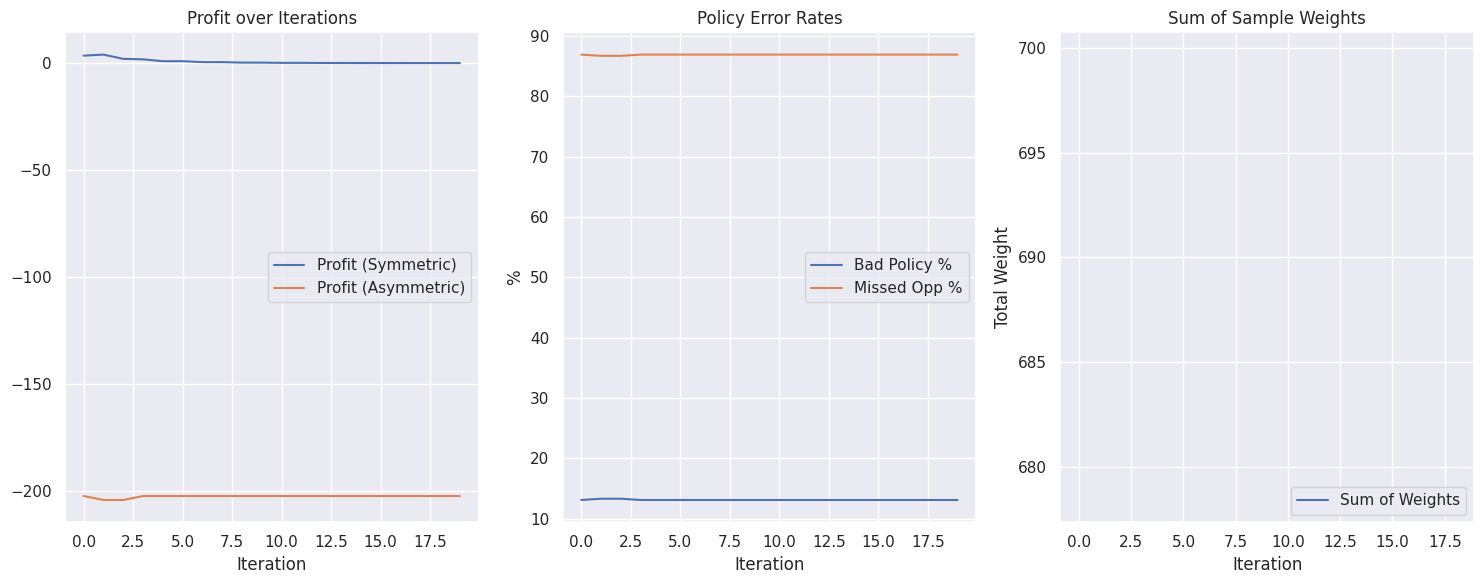

In [17]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# ---- Improved Data Simulation ----
np.random.seed(42)
n = 1000
X = np.random.randn(n, 3)
T = 4 + X[:, 0]  # shifts T to center around M
noise = np.random.normal(0, 2, size=n)
A = np.maximum(0, T + noise)  # observed samples
M = np.full(n, 4.0)  # fixed threshold

# ---- Train-test split ----
X_train, X_test, A_train, A_test, T_train, T_test, M_train, M_test = train_test_split(
    X, A, T, M, test_size=0.3, random_state=42
)

# ---- Init T_hat ----
T_hat_train = pd.Series(A_train).rolling(20, min_periods=1).mean().to_numpy()
T_hat_test = pd.Series(A_test).rolling(20, min_periods=1).mean().to_numpy()

# ---- Utility functions ----
def weight(t_hat, M, sigma=1.0):
    return np.exp(-0.5 * ((t_hat - M)/sigma)**2)

def profit(p, t_hat, M):
    return np.where(p >= M, 0.0, t_hat - p)

def profit_asymmetric(p, A, M, alpha=2.0, beta=1.0):
    mask = p < M
    bad_policy = (mask) & (A > M)
    good_policy = (mask) & (A <= M)

    profit = np.zeros_like(p)
    profit[bad_policy] = -alpha * (A[bad_policy] - p[bad_policy])
    profit[good_policy] = beta * (A[good_policy] - p[good_policy])
    return profit


def evaluate_full(p, t_hat, M, A, alpha=2.0, beta=1.0):
    mse = mean_squared_error(t_hat, A)

    # BAD POLICY: predicted P < M, but A > M
    mask_profitable = A > M
    mask_loss_making = (p < M) & mask_profitable
    total_possible_profit = np.sum(A[mask_profitable] - M[mask_profitable])
    lost_profit = np.sum(A[mask_loss_making] - M[mask_loss_making])
    bad_policy_rate = (lost_profit / total_possible_profit) if total_possible_profit > 1e-8 else 0.0

    # MISSED OPPORTUNITY: predicted P ≥ M, but A > M
    mask_missed = (p >= M) & (A > M)
    missed_opportunity = np.sum(A[mask_missed] - M[mask_missed])
    missed_opportunity_rate = (missed_opportunity / total_possible_profit) if total_possible_profit > 1e-8 else 0.0

    # Profits
    profit_symmetric = np.sum(profit(p, t_hat, M))
    profit_asym = np.sum(profit_asymmetric(p, A, M, alpha=alpha, beta=beta))

    return {
        'mse_T_hat_vs_A': mse,
        'bad_policy_rate': bad_policy_rate,
        'missed_opportunity_rate': missed_opportunity_rate,
        'total_profit_symmetric': profit_symmetric,
        'total_profit_asymmetric': profit_asym
    }


# ---- Train loop ----
n_iter = 10
model = Ridge()

history = []

for i in range(n_iter):
    W_train = weight(T_hat_train, M_train, sigma=2.0)
    
    sum_weights = np.sum(W_train)
    result = evaluate_full(P_test, T_hat_test, M_test, A_test)
    result['sum_weights'] = sum_weights
    history.append(result)

    model.fit(X_train, T_hat_train, sample_weight=W_train)

    P_train = model.predict(X_train)
    P_test = model.predict(X_test)
    
    result = evaluate_full(P_test, T_hat_test, M_test, A_test)
    history.append(result)
    
    print(f"[Iter {i+1}] MSE: {result['mse_T_hat_vs_A']:.2f}, "
          f"Sum Weights: {sum_weights:.2f}, "
          f"Bad Policy: {result['bad_policy_rate']:.1%}, "
          f"Missed Opp: {result['missed_opportunity_rate']:.1%}, "
          f"Profit (sym): {result['total_profit_symmetric']:.2f}, "
          f"Profit (asym): {result['total_profit_asymmetric']:.2f}")


    # Update T_hat
    T_hat_train = 0.5 * T_hat_train + 0.5 * P_train
    T_hat_test = 0.5 * T_hat_test + 0.5 * P_test

# ---- Plotting ----
df_hist = pd.DataFrame(history)
plt.figure(figsize=(15, 6))

# --- Profit ---
plt.subplot(1, 3, 1)
plt.plot(df_hist['total_profit_symmetric'], label='Profit (Symmetric)')
plt.plot(df_hist['total_profit_asymmetric'], label='Profit (Asymmetric)')
plt.title('Profit over Iterations')
plt.xlabel('Iteration')
plt.legend()

# --- Policy Error Rates ---
plt.subplot(1, 3, 2)
plt.plot(df_hist['bad_policy_rate'] * 100, label='Bad Policy %')
plt.plot(df_hist['missed_opportunity_rate'] * 100, label='Missed Opp %')
plt.title('Policy Error Rates')
plt.ylabel('%')
plt.xlabel('Iteration')
plt.legend()

# --- Sum of Weights ---
plt.subplot(1, 3, 3)
plt.plot(df_hist['sum_weights'], label='Sum of Weights')
plt.title('Sum of Sample Weights')
plt.xlabel('Iteration')
plt.ylabel('Total Weight')
plt.legend()

plt.tight_layout()
plt.show()
